# Bioinformatic Screen of Ribozymes

<span style="color:red"> Last edited when?!
#### 170924

In [1]:
# Import Modules

import pandas as pd
import pickle
import numpy as np

In [2]:
sub_library_allSwitches_output_fname = 'all-test.df'
sub_library_onSwitches_output_fname = 'on-test.df'
sub_library_offSwitches_output_fname = 'off-test.df'

In [3]:
def namevar(obj, namespace=globals()):
    '''
    INPUT:
        an object
    OUPUT:
        name of the object
    '''
    return [name for name in namespace if namespace[name] is obj]

def printDF(DF,n=5):
    '''
    DEPENDENCIES:
        requires namevar
    INPUT:
        DF
    
    OUPTUT:
        Prints with plenty of newlines and the title of the dataframe
    '''
    print('\n\n\n\n\n',namevar(DF),'\n\n',DF.head(n),'\n\n\n\n')

In [4]:
def decimal_to_negative_fold(df, col):
    '''
    INPUT: 
      df  = data frame to operate on 
      col = column to operate on
      
    OUTPUT:
      all values in df[col] that are 0<value<1 will be changed to 1/value, representing the fold change
    '''
    df.loc[df[col]<1,col] = -1/ df.loc[df[col]< 1,col]
     

In [5]:
def cbind(colSourceDF, colDestinationDF, indexCol, cbindCol, debug=False):
    """
    INPUT: 
        colSourceDF - DF with column to be added to outputDF
        colDestinationDF - DF that the column will be added to
        indexCol - column in both colDestinationDF and colSourceDF that is used as index
        cbindCol - column to be bound
                 - if cbindCol = bind_all, the entire data frame will be concatenated
    OUTPUT:
        colDestinationDF is returned with columns bound and index reset
    """
    # Set indices of both columns
    colSourceDF      = colSourceDF     .set_index(indexCol)
    colDestinationDF = colDestinationDF.set_index(indexCol)
    
    # debug
    if debug == True:
        printDF(colSourceDF     , 'colSourceDF')
        printDF(colDestinationDF, 'colDestDF  ')
    
    # cbind
    if cbindCol == 'bind_all':
        colDestinationDF = pd.concat([colSourceDF, colDestinationDF], axis=1)
        
    else:
        colDestinationDF = pd.concat([colSourceDF[cbindCol], colDestinationDF], axis=1)
    
    # reset index to index col name
    colDestinationDF.index.name = indexCol
    # debug
    if debug == True:
        printDF(colSourceDF     , 'colSourceDF')
        printDF(colDestinationDF, 'colDestDF  ')
    
    colSourceDF      = colSourceDF     .reset_index()
    colDestinationDF = colDestinationDF.reset_index()

    # debug
    if debug == True:
        printDF(colSourceDF     , 'colSourceDF')
        printDF(colDestinationDF, 'colDestDF  ')
    
    return(colDestinationDF)

# Analyze with UMIs 

<span style="color:blue">• Specify file names</span>

In [6]:
aptamer = '811'

# === DEFINE FILE NAMES === #

# Define sub directory
inputHome = './input-files/'+aptamer+'/umi-files/'

# 8 bins P+S- fnames
bin1_neg = inputHome+"811-PpSm1.tsv"
bin2_neg = inputHome+"811-PpSm2.tsv"
bin3_neg = inputHome+"811-PpSm3.tsv"
bin4_neg = inputHome+"811-PpSm4.tsv"
bin5_neg = inputHome+"811-PpSm5.tsv"
bin6_neg = inputHome+"811-PpSm6.tsv"
bin7_neg = inputHome+"811-PpSm7.tsv"
bin8_neg = inputHome+"811-PpSm8.tsv" 

# 8 bins P+S+ fnames
bin1_pos = inputHome+"811-PpSp1.tsv"
bin2_pos = inputHome+"811-PpSp2.tsv"
bin3_pos = inputHome+"811-PpSp3.tsv"
bin4_pos = inputHome+"811-PpSp4.tsv"
bin5_pos = inputHome+"811-PpSp5.tsv"
bin6_pos = inputHome+"811-PpSp6.tsv"
bin7_pos = inputHome+"811-PpSp7.tsv"
bin8_pos = inputHome+"811-PpSp8.tsv"

# Post-transduction analysis fname
pretransductionFname = inputHome+'170818-Fat-811-diversity-statistics.tsv'

# Library fnames
referenceHome    = "./reference-libraries-fasta/"
twist_library    = referenceHome+"famin811-stem_apt.fasta"
unmapped_library = referenceHome+""




<span style="color:blue">• Read in .fasta bowtie2 reference file as DF so you know all sequences that are possible



In [8]:
# === READ IN COMPLETE LIBRARY === #

# Define a funciton to create data frame by reading library.fasta files without headers
import itertools
def read_tsv(fname):
    '''returns empty dataframe with indicies = sequences. Done by reading every second file in the .fasta file'''
    # Read .fasta file
    with open(fname, 'r') as fileH: 
        sequences = set() # non-redundant repository of sequences observed # Sets are faster
        for seq_description,seq_sequence in itertools.zip_longest(*[fileH]*2):
            sequences.add(seq_description[1:-1])
    DF = pd.DataFrame({'RNAME':list(sequences)})
    DF = DF.groupby(['RNAME']).sum() # Make sequences the indexs
    return (DF)

# Create library dataframes by reading the library.fasta files
twistLibDF    = read_tsv(twist_library)
# unmappedLibDF = read_tsv(unmapped_library)

# Concatenate TWIST library and recycled library
#libraryDF = pd.concat([twistLibDF, unmappedLibDF])
libraryDF = twistLibDF
libraryDF.index.names = ['RNAME']

<span style="color:blue">• Create a DF for every bin, lable with bin # and condition (FAR+ or FAR-)

<span style="color:blue">• Determine the sample size for each library member

In [9]:
# Define a function that strips information from binx.sam files
def stripBin_umi(bin_file, bin_number, condition):
    ''' 
    INPUT: 
        1. bin_file - grouped.umi.tsv file 
        2. bin_number - what bin this file hails from
        3. what selection condition the bin was under
        
    OUTPUT: (see print statements below to gauge format of DFs)
        1. binDF - a DF formatted for easily understanding the mean/median bin
        2. binDF - a DF formatted for easily extrapolationg sample size for each library member
        3. bin_umiDF - a DF formatted for easy extraction of umi analysis for determining true coverage
    '''
    # Read in file
    binDF = pd.read_csv(bin_file, usecols=[1,5],header=0, delimiter='\t')
    binDF.columns = ['RNAME','FINAL_UMI']
    binDF['UMI_COVERAGE'] = 1
    
    #  group by RNAME and FINAL_UMI
    binDF = binDF.groupby(['RNAME','FINAL_UMI']).sum().reset_index()

    # instantiate coverage DF
    coverageDF     = binDF.fillna(np.NaN) # avoid a situation where changing 1 DF will change the other 
    coverageDF['UMI_COVERAGE'] = 1

    # determine true coverage
    coverageDF = coverageDF.groupby(['RNAME']).sum()
    coverageDF = coverageDF.rename(columns={'UMI_COVERAGE':'LIBRARY_MEMBER_UMI_COVERAGE_'+condition})
    
    
    # Ascribe bin number, Calculate GC content
    coverageDF['BIN'] = 1
    coverageDF = coverageDF.reset_index()
    
    binDF['BIN']  = bin_number
    binDF['GC_CONTENT']    = binDF['FINAL_UMI'].apply(lambda FINAL_UMI: (FINAL_UMI.count('G') + FINAL_UMI.count('C'))/10)
    
    # test print
#     printDF(binDF,15)
#     printDF(coverageDF,15)

    return(binDF, coverageDF)

# Test
# bin1_posDF, bin1_pos_coverageDF = stripBin_umi(bin1_pos,bin_number=1, condition='POS')

In [52]:
# Load binX.sam files
# bin1_posDF, bin1_pos_coverageDF = stripBin_umi(bin1_pos,bin_number=1, condition='POS')
# bin2_posDF, bin2_pos_coverageDF = stripBin_umi(bin2_pos,bin_number=2, condition='POS')
# bin3_posDF, bin3_pos_coverageDF = stripBin_umi(bin3_pos,bin_number=3, condition='POS')
# bin4_posDF, bin4_pos_coverageDF = stripBin_umi(bin4_pos,bin_number=4, condition='POS')
# bin5_posDF, bin5_pos_coverageDF = stripBin_umi(bin5_pos,bin_number=5, condition='POS')
# bin6_posDF, bin6_pos_coverageDF = stripBin_umi(bin6_pos,bin_number=6, condition='POS')
# bin7_posDF, bin7_pos_coverageDF = stripBin_umi(bin7_pos,bin_number=7, condition='POS')
# bin8_posDF, bin8_pos_coverageDF = stripBin_umi(bin8_pos,bin_number=8, condition='POS')

bin1_negDF, bin1_neg_coverageDF = stripBin_umi(bin1_neg,bin_number=1, condition='NEG')
bin2_negDF, bin2_neg_coverageDF = stripBin_umi(bin2_neg,bin_number=2, condition='NEG')
bin3_negDF, bin3_neg_coverageDF = stripBin_umi(bin3_neg,bin_number=3, condition='NEG')
bin4_negDF, bin4_neg_coverageDF = stripBin_umi(bin4_neg,bin_number=4, condition='NEG')
bin5_negDF, bin5_neg_coverageDF = stripBin_umi(bin5_neg,bin_number=5, condition='NEG')
bin6_negDF, bin6_neg_coverageDF = stripBin_umi(bin6_neg,bin_number=6, condition='NEG')
bin7_negDF, bin7_neg_coverageDF = stripBin_umi(bin7_neg,bin_number=7, condition='NEG')
bin8_negDF, bin8_neg_coverageDF = stripBin_umi(bin8_neg,bin_number=8, condition='NEG')

In [53]:
printDF(libraryDF)
printDF(bin1_negDF)
printDF(bin1_neg_coverageDF)






 ['twistLibDF', 'libraryDF'] 

 Empty DataFrame
Columns: []
Index: [AAAAA...TTTTT, AAAAC...GTTTT, AAAAG...CTTTT, AAAAG...TTTTT, AAAAT...ATTTT] 









 ['bin1_negDF'] 

 Empty DataFrame
Columns: [RNAME, FINAL_UMI, UMI_COVERAGE, BIN, GC_CONTENT]
Index: [] 









 ['bin1_neg_coverageDF'] 

 Empty DataFrame
Columns: [RNAME, FINAL_UMI, LIBRARY_MEMBER_UMI_COVERAGE_NEG, BIN]
Index: [] 






<span style="color:blue">• Concatenate bin DF rows into a single DF for pos and for neg

<span style="color:blue">• Calculate bin mean and median for pos and neg

In [20]:
# Concatenate bins
#binspreadDFpos = pd.concat(   [   \
#                bin1_posDF,\
#                bin2_posDF,\
#                bin3_posDF,\
#                bin4_posDF,\
#                bin5_posDF,\
#                bin6_posDF,\
#                bin7_posDF,\
#                bin8_posDF ], ignore_index=True    )
binspreadDFpos = pd.DataFrame()



binspreadDFneg = pd.concat(   [   \
                bin1_negDF,\
                bin2_negDF,\
                bin3_negDF,\
                bin4_negDF,\
                bin5_negDF,\
                bin6_negDF,\
                bin7_negDF,\
                bin8_negDF   ], ignore_index=True   )

#coverageDFpos = pd.concat([\
#    bin1_pos_coverageDF,\
#    bin2_pos_coverageDF,\
#    bin3_pos_coverageDF,\
#    bin4_pos_coverageDF,\
#    bin5_pos_coverageDF,\
#    bin6_pos_coverageDF,\
#    bin7_pos_coverageDF,\
#    bin8_pos_coverageDF ])
covrageDFpos = pd.DataFrame()

coverageDFneg = pd.concat([\
    bin1_neg_coverageDF,\
    bin2_neg_coverageDF,\
    bin3_neg_coverageDF,\
    bin4_neg_coverageDF,\
    bin5_neg_coverageDF,\
    bin6_neg_coverageDF,\
    bin7_neg_coverageDF,\
    bin8_neg_coverageDF ])

In [21]:
# printDF(binspreadDFpos)
# printDF(binspreadDFneg)
# printDF(coverageDFpos)
# printDF(coverageDFneg)

In [24]:
# Calculate bin mean and median for pos
#statsDFpos = binspreadDFpos.loc[:,['RNAME','BIN']].groupby('RNAME',as_index=False).mean() #instantiate DF
#statsDFpos.columns = ['RNAME','BIN_MEAN_POS'] # Change name of column
#statsDFpos['BIN_MEDIAN_POS'] = binspreadDFpos.loc[:,['RNAME','BIN']].groupby('RNAME',as_index=False).median()['BIN'] # add new column with new transform


# Calculate bin mean and median for neg
statsDFneg = binspreadDFneg.loc[:,['RNAME','BIN']].groupby('RNAME',as_index=False).mean()
statsDFneg.columns = ['RNAME','BIN_MEAN_NEG']
statsDFneg['BIN_MEDIAN_NEG'] = binspreadDFneg.loc[:,['RNAME','BIN']].groupby('RNAME',as_index=False).median()['BIN']


In [ ]:
# printDF(statsDFpos)
# printDF(statsDFneg)

In [25]:
# Sum counts for sample size DFs
#coverageDFpos = coverageDFpos.loc[:,['RNAME','LIBRARY_MEMBER_UMI_COVERAGE_POS']].groupby('RNAME', as_index=False).sum()
coverageDFneg = coverageDFneg.loc[:,['RNAME','LIBRARY_MEMBER_UMI_COVERAGE_NEG']].groupby('RNAME', as_index=False).sum()

In [ ]:
# printDF(coverageDFpos)
# printDF(coverageDFneg)

In [28]:
# coverageDF = pd.concat([coverageDFpos, coverageDFneg], axis=0)
coverageDF = pd.concat([ coverageDFneg], axis=0)
coverageDF = coverageDF.groupby('RNAME',as_index=False).sum()

In [29]:
# printDF(coverageDF)

In [30]:
# print(len(statsDFpos[statsDFpos['RNAME']=='TGAGA...TCTCA']))
# print(len(statsDFneg[statsDFneg['RNAME']=='TGAGA...TCTCA']))

# print(len(statsDFpos['TGAGA...TCTCA']))
# print(len(statsDFneg['TGAGA...TCTCA']))

<span style="color:blue">• Combine statsDFpos and statsDFneg

In [33]:
#statsDF = cbind(colSourceDF = statsDFpos,\
#                colDestinationDF = statsDFneg,\
#                indexCol = 'RNAME',\
#                cbindCol = 'bind_all')

statsDF = statsDFneg

In [ ]:
# printDF(statsDF)
# printDF(coverageDF)

In [35]:
#statsDF = cbind(colSourceDF      = coverageDF,\
#                colDestinationDF = statsDF,\
#                indexCol         = 'RNAME',\
#                cbindCol         = 'LIBRARY_MEMBER_UMI_COVERAGE_POS')

statsDF = cbind(colSourceDF      = coverageDF,\
                colDestinationDF = statsDF,\
                indexCol         = 'RNAME',\
                cbindCol         = 'LIBRARY_MEMBER_UMI_COVERAGE_NEG')

In [ ]:
# printDF(statsDF)

<span style="color:blue">• Add information about abundance of member in the plasmid library

In [36]:
pretransductionDF  = pd.read_csv(pretransductionFname, usecols=[1,7,8,9,12,14], header=0, sep='\t')


In [37]:
printDF(pretransductionDF)






 ['pretransductionDF'] 

            RNAME  PLASMID_AU_ABUNDANCE_MEDIAN  P_PLUS_AU_ABUNDANCE_MEDIAN  \
0  AAAAA...TTTTT                     1.034483                    1.871795   
1  AAAAC...GTTTT                     1.097701                    1.367521   
2  AAAAG...CTTTT                     1.137931                    1.478632   
3  AAAAG...TTTTT                     1.057471                    2.555556   
4  AAAAT...ATTTT                     0.793103                    1.102564   

   P_MINUS_AU_ABUNDANCE_MEDIAN  DELTA_PKG_EFFICIENCY_MEDIAN  \
0                         1.08                     0.791795   
1                         2.04                    -0.672479   
2                         1.54                    -0.061368   
3                         3.58                    -1.024444   
4                         1.70                    -0.597436   

   FOLD_PKG_EFFICIENCY_MEDIAN  
0                    1.733143  
1                    0.670354  
2                    0.960151  

In [38]:
statsDF = cbind( colSourceDF      = pretransductionDF,\
                colDestinationDF = statsDF,\
                indexCol         = 'RNAME',\
                cbindCol         = 'bind_all')

decimal_to_negative_fold(statsDF, 'FOLD_PKG_EFFICIENCY_MEDIAN')

In [39]:
# printDF(statsDF)

In [40]:
print('Number of NaN in PLASMID_AU_ABUNDANCE_MEDIAN:', statsDF['PLASMID_AU_ABUNDANCE_MEDIAN'].isnull().sum())
print('Number of NaN in P_PLUS_AU_ABUNDANCE_MEDIAN (due to detection in P+ or P- only):', statsDF['P_PLUS_AU_ABUNDANCE_MEDIAN'].isnull().sum())
print('Number of NaN in P_MINUS_AU_ABUNDANCE_MEDIAN (due to detection in P+ or P- only):', statsDF['P_MINUS_AU_ABUNDANCE_MEDIAN'].isnull().sum())

print('Number of NaN in LIBRARY_MEMBER_UMI_COVERAGE_POS:', statsDF['LIBRARY_MEMBER_UMI_COVERAGE_POS'].isnull().sum())
print('Number of NaN in LIBRARY_MEMBER_UMI_COVERAGE_NEG:', statsDF['LIBRARY_MEMBER_UMI_COVERAGE_NEG'].isnull().sum())

# printDF(pretransductionDF)
# printDF(statsDF[statsDF['P_MINUS_AU_ABUNDANCE_MEDIAN'].isnull()])

Number of NaN in PLASMID_AU_ABUNDANCE_MEDIAN: 0
Number of NaN in P_PLUS_AU_ABUNDANCE_MEDIAN (due to detection in P+ or P- only): 36
Number of NaN in P_MINUS_AU_ABUNDANCE_MEDIAN (due to detection in P+ or P- only): 7


KeyError: 'LIBRARY_MEMBER_UMI_COVERAGE_POS'

<span style="color:blue">• Determine Fold and Delta change in bin occurance



In [41]:
statsDF['DELTA_PpSpm_MEAN']   = statsDF['BIN_MEAN_POS']   - statsDF['BIN_MEAN_NEG']
statsDF['DELTA_PpSpm_MEDIAN'] = statsDF['BIN_MEDIAN_POS'] - statsDF['BIN_MEDIAN_NEG']
statsDF[ 'FOLD_PpSpm_MEAN']    = statsDF['BIN_MEAN_POS']   / statsDF['BIN_MEAN_NEG']
statsDF[ 'FOLD_PpSpm_MEDIAN']  = statsDF['BIN_MEDIAN_POS'] / statsDF['BIN_MEDIAN_NEG']


KeyError: 'BIN_MEAN_POS'

In [ ]:
# printDF(statsDF)

<span style="color:blue">• Separate statsDF into several DFs depending on if the members were detected only in B+, B- or both

In [43]:
#statsDF_inPOS  = statsDF[statsDF['LIBRARY_MEMBER_UMI_COVERAGE_NEG'].isnull()]
statsDF_inNEG  = statsDF[statsDF['LIBRARY_MEMBER_UMI_COVERAGE_POS'].isnull()]
#statsDF_inBOTH = statsDF.dropna(how='any',axis=0,subset=['LIBRARY_MEMBER_UMI_COVERAGE_POS','LIBRARY_MEMBER_UMI_COVERAGE_NEG'])

KeyError: 'LIBRARY_MEMBER_UMI_COVERAGE_POS'

In [ ]:
# printDF(statsDF_inPOS  )
# printDF(statsDF_inNEG  )
# printDF(statsDF_inBOTH,50)

<span style="color:blue">• Fill NaNs in P_PLUS_AU_ABUNDANCE_MEDIAN and P_MINUS_AU_ABUNDANCE_MEDIAN with their respective minimums

In [ ]:
# statsDF['P_PLUS_AU_ABUNDANCE_MEDIAN' ] = statsDF['P_PLUS_AU_ABUNDANCE_MEDIAN'].fillna(statsDF['P_PLUS_AU_ABUNDANCE_MEDIAN' ].min())
# statsDF['P_MINUS_AU_ABUNDANCE_MEDIAN'] = statsDF['P_MINUS_AU_ABUNDANCE_MEDIAN'].fillna(statsDF['P_MINUS_AU_ABUNDANCE_MEDIAN'].min())

In [ ]:
# print('Number of NaN in PLASMID_AU_ABUNDANCE_MEDIAN:', statsDF['PLASMID_AU_ABUNDANCE_MEDIAN'].isnull().sum())
# print('Number of NaN in P_PLUS_AU_ABUNDANCE_MEDIAN (due to detection in P+ or P- only):', statsDF['P_PLUS_AU_ABUNDANCE_MEDIAN'].isnull().sum())
# print('Number of NaN in P_MINUS_AU_ABUNDANCE_MEDIAN (due to detection in P+ or P- only):', statsDF['P_MINUS_AU_ABUNDANCE_MEDIAN'].isnull().sum())

<span style="color:blue">• Change αB values that are 0<x<1 to a fold change by dividing it by zero

In [ ]:
decimal_to_negative_fold(statsDF_inBOTH, 'FOLD_PpSpm_MEAN')
decimal_to_negative_fold(statsDF_inBOTH, 'FOLD_PpSpm_MEDIAN')
decimal_to_negative_fold(statsDF_inPOS,  'FOLD_PpSpm_MEAN')
decimal_to_negative_fold(statsDF_inPOS,  'FOLD_PpSpm_MEDIAN')
decimal_to_negative_fold(statsDF_inNEG,  'FOLD_PpSpm_MEAN')
decimal_to_negative_fold(statsDF_inNEG,  'FOLD_PpSpm_MEDIAN')


In [ ]:
print('statsDF_inBOTH[LIBRARY_MEMBER_UMI_COVERAGE_NEG].median() --  ', statsDF_inBOTH['LIBRARY_MEMBER_UMI_COVERAGE_NEG'].median())
print('statsDF_inBOTH[LIBRARY_MEMBER_UMI_COVERAGE_POS].median() --  ', statsDF_inBOTH['LIBRARY_MEMBER_UMI_COVERAGE_POS'].median())


# printDF(statsDF)
# printDF(statsDF_inBOTH)


<span style="color:blue">• Ascribe a boolean value to LIBRARY_MEMBER_UMI_COVERAGE describing whether or not it higher than the threshold

In [ ]:
# Denote which members in POS are above the median or less than the median
statsDF_inBOTH.loc[statsDF_inBOTH['LIBRARY_MEMBER_UMI_COVERAGE_POS']>=statsDF_inBOTH['LIBRARY_MEMBER_UMI_COVERAGE_POS'].median(),'LIBRARY_MEMBER_UMI_COVERAGE_POS_BOOLEAN'] = 'GREATER_THAN_MEDIAN'
statsDF_inBOTH.loc[statsDF_inBOTH['LIBRARY_MEMBER_UMI_COVERAGE_POS']< statsDF_inBOTH['LIBRARY_MEMBER_UMI_COVERAGE_POS'].median(),'LIBRARY_MEMBER_UMI_COVERAGE_POS_BOOLEAN'] = 'LESS_THAN_MEDIAN'

In [ ]:
# Denote which members in NEG are above the median or less than the median
statsDF_inBOTH.loc[statsDF_inBOTH['LIBRARY_MEMBER_UMI_COVERAGE_NEG']>=statsDF_inBOTH['LIBRARY_MEMBER_UMI_COVERAGE_NEG'].median(),'LIBRARY_MEMBER_UMI_COVERAGE_NEG_BOOLEAN'] = 'GREATER_THAN_MEDIAN'
statsDF_inBOTH.loc[statsDF_inBOTH['LIBRARY_MEMBER_UMI_COVERAGE_NEG']< statsDF_inBOTH['LIBRARY_MEMBER_UMI_COVERAGE_NEG'].median(),'LIBRARY_MEMBER_UMI_COVERAGE_NEG_BOOLEAN'] = 'LESS_THAN_MEDIAN'

In [ ]:
# printDF(statsDF_inBOTH,50)

# Plotting

Must load these extensions to use R.

**%%R -i** *dataframe imported* **-w** *width of plot* **-h** *height of plot* **-u** *units*

In [44]:
%load_ext rpy2.ipython

In [45]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='<U9')

# Assess UMI and Library Member Coverage

In [46]:
binspreadDF = pd.concat([binspreadDFpos, binspreadDFneg])

In [47]:
binspreadDFpos_corrP = binspreadDFpos.corr(method='pearson')
binspreadDFpos_corrS = binspreadDFpos.corr(method='spearman')

binspreadDFneg_corrP = binspreadDFneg.corr(method='pearson')
binspreadDFneg_corrS = binspreadDFneg.corr(method='spearman')

In [49]:
#print(binspreadDFpos['UMI_COVERAGE'].max())
print(binspreadDFneg['UMI_COVERAGE'].max())
printDF(binspreadDF)
printDF(binspreadDFpos_corrP)
printDF(binspreadDFpos_corrS)
printDF(binspreadDFneg_corrP)
printDF(binspreadDFneg_corrS)

nan





 ['binspreadDF'] 

 Empty DataFrame
Columns: [RNAME, FINAL_UMI, UMI_COVERAGE, BIN, GC_CONTENT]
Index: [] 









 ['binspreadDFpos_corrP'] 

 Empty DataFrame
Columns: []
Index: [] 









 ['binspreadDFpos_corrS'] 

 Empty DataFrame
Columns: []
Index: [] 









 ['binspreadDFneg_corrP'] 

               RNAME  FINAL_UMI  UMI_COVERAGE  BIN  GC_CONTENT
RNAME           NaN        NaN           NaN  NaN         NaN
FINAL_UMI       NaN        NaN           NaN  NaN         NaN
UMI_COVERAGE    NaN        NaN           NaN  NaN         NaN
BIN             NaN        NaN           NaN  NaN         NaN
GC_CONTENT      NaN        NaN           NaN  NaN         NaN 









 ['binspreadDFneg_corrS'] 

               RNAME  FINAL_UMI  UMI_COVERAGE  BIN  GC_CONTENT
RNAME           NaN        NaN           NaN  NaN         NaN
FINAL_UMI       NaN        NaN           NaN  NaN         NaN
UMI_COVERAGE    NaN        NaN           NaN  NaN         NaN
BIN             NaN        NaN    

In [51]:
printDF(binspreadDFneg)






 ['binspreadDFneg'] 

 Empty DataFrame
Columns: [RNAME, FINAL_UMI, UMI_COVERAGE, BIN, GC_CONTENT]
Index: [] 






<span style="color:blue">• What does the distribution of frequencies look like when considering umi-stem marriages?


In [54]:
%%R -i binspreadDFpos -i aptamer -w 950 -h 700 -u px

ggplot(binspreadDFpos, aes(x=UMI_COVERAGE)) +
    geom_histogram(stat='count',binwidth = 1) +
    labs(title="UMI Coverage Analysis",
         subtitle=paste('P+S+ Fat ',aptamer,sep=''),
         x="\nCount of UMI-Member Marriage\n", 
         y="Frequency\n") +
    xlim(c(0,225)) +
    scale_y_continuous(breaks = seq(0,100000, by = 10000),limits=c(0,80000)) +
    theme(axis.text=element_text(size=18),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=32,face="bold"),
        plot.subtitle=element_text(size=30),
        plot.caption=element_text(size=12),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  Ignoring unknown parameters: binwidth, bins, pad

  warnings.warn(x, RRuntimeWarning)
/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in eval(expr, envir, enclos) : object 'UMI_COVERAGE' not found

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error in eval(expr, envir, enclos) : object 'UMI_COVERAGE' not found


/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  Ignoring unknown parameters: binwidth, bins, pad

  warnings.warn(x, RRuntimeWarning)


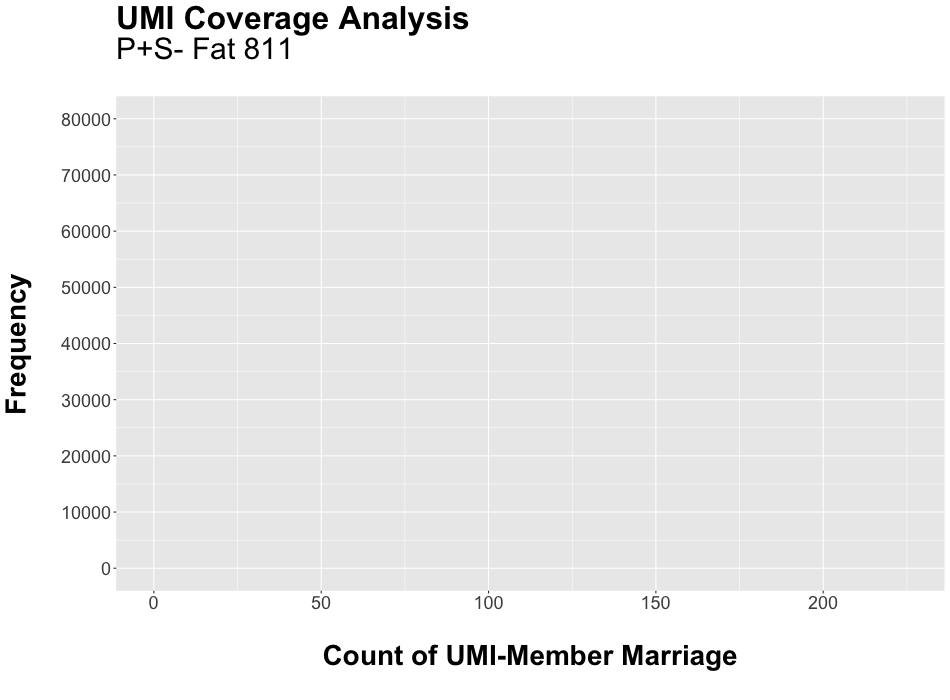

In [50]:
%%R -i binspreadDFneg -i aptamer -w 950 -h 700 -u px

ggplot(binspreadDFneg, aes(x=UMI_COVERAGE)) +
    geom_histogram(stat='count',binwidth = 1) +
    labs(title="UMI Coverage Analysis",
         subtitle=paste('P+S- Fat ',aptamer,'\n',sep=''),
         x="\nCount of UMI-Member Marriage\n", 
         y="Frequency\n") +
    xlim(c(0,225)) +
    scale_y_continuous(breaks = seq(0,100000, by = 10000),limits=c(0,80000)) +
    theme(axis.text=element_text(size=18),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=32,face="bold"),
        plot.subtitle=element_text(size=30),
        plot.caption=element_text(size=12),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

In [ ]:
%%R -i statsDF_inBOTH -i aptamer -w 950 -h 700 -u px

ggplot(statsDF_inBOTH, aes(x=LIBRARY_MEMBER_UMI_COVERAGE_POS)) +
    geom_histogram(stat='count',binwidth = 1) +
    labs(title="Distribution of Coverage",
         subtitle=paste('Using UMIs\nP+S+ Fat ',aptamer,'\n',sep=''),
         x="\nCount of UMI-Member Marriage\n", 
         y="Frequency\n") +
    xlim(c(0,225)) +
    scale_y_continuous(breaks = seq(0,100000, by = 100),limits=c(0,500)) +
    theme(axis.text=element_text(size=18),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=32,face="bold"),
        plot.subtitle=element_text(size=30),
        plot.caption=element_text(size=12),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

In [ ]:
%%R -i statsDF_inBOTH -i aptamer -w 950 -h 700 -u px

ggplot(statsDF_inBOTH, aes(x=LIBRARY_MEMBER_UMI_COVERAGE_NEG)) +
    geom_histogram(stat='count',binwidth = 1) +
    labs(title="Distribution of Coverage",
         subtitle=paste('Using UMIs\nP+S- Fat ',aptamer,'\n',sep=''),
         x="\nCount of UMI-Member Marriage\n", 
         y="Frequency\n") +
    xlim(c(0,225)) +
    scale_y_continuous(breaks = seq(0,100000, by = 100),limits=c(0,500)) +
    theme(axis.text=element_text(size=18),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=32,face="bold"),
        plot.subtitle=element_text(size=30),
        plot.caption=element_text(size=12),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

<span style="color:blue">• How does GC bias affect umi amplification?

In [ ]:
%%R -i binspreadDFpos -i aptamer -w 800 -h 800 -u px


ggplot(binspreadDFpos, aes(x=GC_CONTENT,y=UMI_COVERAGE)) +
    stat_density2d(aes(fill=..level..,alpha=..level..),geom='polygon',colour='black') + 
    scale_fill_continuous(low="green",high="red") +
    geom_smooth(method=lm,linetype=2,colour="red",se=F) + 
    guides(alpha="none") +
    geom_point() +
    labs(title='Correlation Between UMI GC Content and UMI Count', 
         subtitle=paste('P+S+ Fat ',aptamer, sep=''), 
         x='\nGC Content of UMI',
         y='Count of UMI\n') +
    scale_x_continuous(breaks = seq(0,1, by = .1),limits=c(0,1)) +
    scale_y_continuous(breaks = seq(0,1000, by = 50),limits=c(0,250)) +
    theme(axis.text=element_text(size=28),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=22,face="bold"),
        plot.subtitle=element_text(size=25),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

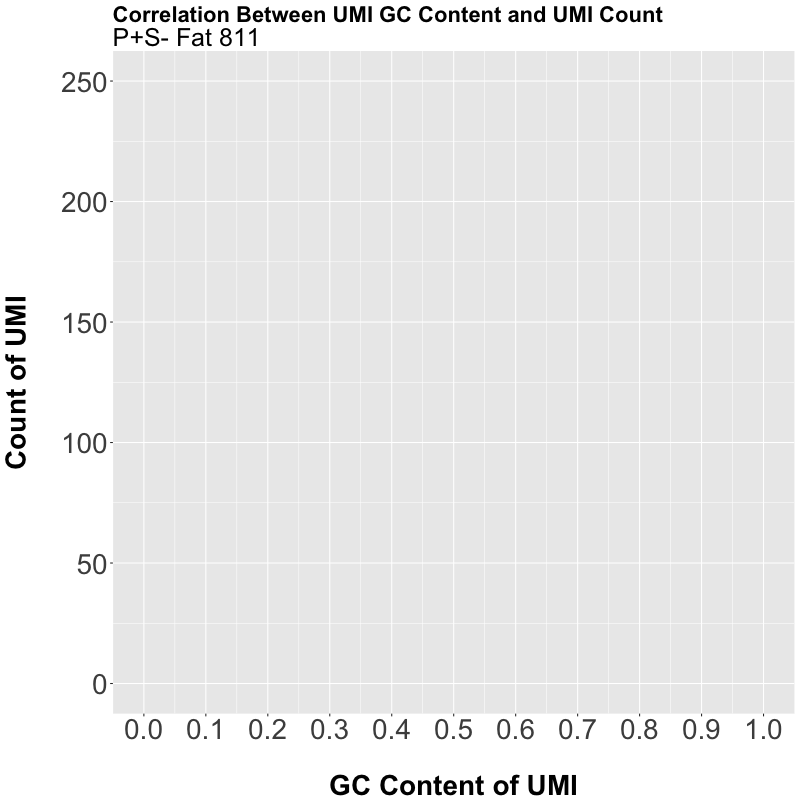

In [55]:
%%R -i binspreadDFneg -i aptamer -w 800 -h 800 -u px


ggplot(binspreadDFneg, aes(x=GC_CONTENT,y=UMI_COVERAGE)) +
    stat_density2d(aes(fill=..level..,alpha=..level..),geom='polygon',colour='black') + 
    scale_fill_continuous(low="green",high="red") +
    geom_smooth(method=lm,linetype=2,colour="red",se=F) + 
    guides(alpha="none") +
    geom_point() +
    labs(title='Correlation Between UMI GC Content and UMI Count', 
         subtitle=paste('P+S- Fat ',aptamer, sep=''), 
         x='\nGC Content of UMI',
         y='Count of UMI\n') +
    scale_x_continuous(breaks = seq(0,1, by = .1),limits=c(0,1)) +
    scale_y_continuous(breaks = seq(0,1000, by = 50),limits=c(0,250)) +
    theme(axis.text=element_text(size=28),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=22,face="bold"),
        plot.subtitle=element_text(size=25),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

In [ ]:
%%R -i binspreadDFpos -i aptamer -w 800 -h 800 -u px

# Does GC content of UMI correlate with higher count of UMI?

title = 'Correlation Between UMI GC Content and UMI Count'
subtitle = paste(aptamer,'\nData from P+ and P-', sep='')

ggplot(binspreadDFpos, aes(x=GC_CONTENT,y=UMI_COVERAGE)) +
    stat_density_2d(geom = "point", aes(size = ..density..), n = 20, contour = FALSE) +
    labs(title=title, subtitle=subtitle, x='\nGC Content of UMI',y='Count of UMI\n') +
    scale_x_continuous(breaks = seq(0,1, by = .1),limits=c(0,1)) +
    scale_y_continuous(breaks = seq(0,1000, by = 50),limits=c(0,250)) +
    theme(axis.text=element_text(size=28),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=22,face="bold"),
        plot.subtitle=element_text(size=25),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

In [ ]:
%%R -i binspreadDFneg -i aptamer -w 800 -h 800 -u px

# Does GC content of UMI correlate with higher count of UMI?

title = 'Correlation Between UMI GC Content and UMI Count'
subtitle = paste(aptamer,'\nData from P+ and P-', sep='')

ggplot(binspreadDFneg, aes(x=GC_CONTENT,y=UMI_COVERAGE)) +
    stat_density_2d(geom = "point", aes(size = ..density..), n = 20, contour = FALSE) +
    labs(title=title, subtitle=subtitle, x='\nGC Content of UMI',y='Count of UMI\n') +
    scale_x_continuous(breaks = seq(0,1, by = .1),limits=c(0,1)) +
    scale_y_continuous(breaks = seq(0,1000, by = 50),limits=c(0,250)) +
    theme(axis.text=element_text(size=28),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=22,face="bold"),
        plot.subtitle=element_text(size=25),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

<span style="color:blue">• Does the bin correlate with the read coverage?

In [ ]:
%%R -i binspreadDFpos -i aptamer -w 800 -h 800 -u px


ggplot(binspreadDFpos, aes(x=BIN,y=UMI_COVERAGE)) +
    stat_density2d(aes(fill=..level..,alpha=..level..),geom='polygon',colour='black') + 
    scale_fill_continuous(low="green",high="red") +
    geom_smooth(method=lm,linetype=2,colour="red",se=F) + 
    guides(alpha="none") +
    geom_point() +
    labs(title='Correlation Between UMI GC Content and UMI Count', 
         subtitle=paste('P+S+ Fat ',aptamer, sep=''), 
         x='\nGC Content of UMI',
         y='Count of UMI\n') +
    scale_x_continuous(breaks = seq(0,10, by = 1),limits=c(0,9)) +
    scale_y_continuous(breaks = seq(0,1000, by = 50),limits=c(0,250)) +
    theme(axis.text=element_text(size=28),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=22,face="bold"),
        plot.subtitle=element_text(size=25),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

In [ ]:
%%R -i binspreadDFpos -i aptamer -w 2000 -h 800 -u px

binspreadDFpos$BIN = factor(binspreadDFpos$BIN, levels = c("1", "2", "3", "4",'5','6','7','8'))

ggplot(binspreadDFpos, aes(x=BIN,y=UMI_COVERAGE)) +
    geom_violin(adjust=.5) +
    labs(title='Correlation Between UMI GC Content and UMI Count', 
         subtitle=paste('P+S+ Fat ',aptamer, sep=''), 
         x='\nGC Content of UMI',
         y='Count of UMI\n') +
    scale_y_continuous(breaks = seq(0,1000, by = 50),limits=c(0,250)) +
    scale_x_discrete(lab= c("1", "2", "3", "4",'5','6','7','8')) +
    theme(axis.text=element_text(size=28),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=32,face="bold"),
        plot.subtitle=element_text(size=18),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))


1. **ΔB > 0**  corresponds to a high functioning **on-switch**

2. **ΔB < 0** corresponds to a high functioning **off-switch**

1. **αB > 1**  corresponds to a high functioning **on-switch**

2. **αB < 1** corresponds to a high functioning **off-switch**

To investigate how the library of switches performed and the prevelances of on- and off-switches, we will graph the Δ for all library members where...

        ΔΒ = bin_mean(+FAR) - bin_mean(-FAR)
        αB = bin_mean(+FAR) ÷ bin_mean(+FAR)

# Screen for (1) high dynamic range (2) low basal

In [ ]:
# Relevant DFs
# print(statsDF_inboth.head())


<span style='color:red'>MAKE SURE YOU CHANGE DATE!!

In [ ]:
date = '170825'

<span style="color:blue">• Designate which switches are on-switches and which are off

In [ ]:
def designate_switch_type(df):
    '''
    INPUT: 
        df to designate switch types
        
    OUTPUT: 
        Will add correct switch type for both FOLD and DELTA metrics wrt MEAN and MEDIAN
    
    ASSUMPTION: since any ΔB is positive will also yield a positive αB, we do not need to calculate a switch type for both metrics.
    '''
    # off switches ΔB > 0
    df.loc[df['DELTA_PpSpm_MEDIAN']  > 0  ,'SWITCH_TYPE_MEDIAN'] = 'Off-switch'

    # On switches ΔB < 0
    df.loc[df['DELTA_PpSpm_MEDIAN']  < 0  ,'SWITCH_TYPE_MEDIAN'] = 'On-switch'



In [ ]:
designate_switch_type(statsDF_inBOTH)
designate_switch_type(statsDF_inPOS)
designate_switch_type(statsDF_inNEG)


In [ ]:
statsDF_inBOTH_off  = statsDF_inBOTH[statsDF_inBOTH['SWITCH_TYPE_MEDIAN'  ]=='Off-switch']
statsDF_inBOTH_on   = statsDF_inBOTH[statsDF_inBOTH['SWITCH_TYPE_MEDIAN'  ]=='On-switch']

In [ ]:
printDF(statsDF_inBOTH)
# printDF(statsDF_inBOTH_off) 
# printDF(statsDF_inBOTH_on)  

<span style="color:blue">• Screen switches...

1. <span style="color:blue">Filter library members, retaining only members with umi_coverage_pos and umi_coverage_neg greater than the median.</span>
2. <span style="color:blue">Sort the entire list by αB (descending; higher αB is desireable)</span>
3. <span style="color:blue">Set boundaries in the DF by binning αB</span>
4. <span style="color:blue">Sort by median bin in cleavage state (ascending; lower basal is desireable)</span>

In [ ]:
# NOTE!! If bin label has disappeared from the excel sheet at a certain point, it is most likely that the values in the excel sheet exceeded the number of bins there were
def bin_and_order_basal(\
                  offDF,\
                  onDF,\
                  number_keep,\
                  bins,\
                  round_bin_name,\
                  directory,\
                  minimum_lib_coverage,\
                  offDF_fname,\
                  onDF_fname,\
                  offDF_fname_100,\
                  onDF_fname_100):
    '''
    INPUT
        offDF,off-switch data frame
        onDF, on switch data frame
        number_keep, number of members to keep in the 'best of' .tsv file
        bins, bins for soting αB
        round_bin_name, extent to round for bin names
        directory, where to save files?
        minimum_lib_coverage, what is the minimum library coverage to consider the member statistically significant
             
    OUTPUT
        several tsv files based on the screen
    
    
    '''
    
    
    # =====================
    # 1. Filter library members, retaining only members with umi_coverage_pos and umi_coverage_neg greater than the median.
    
    # Filter for POS and NEG for ON switches; Filter for POS and NEG for OFF switches
    onDF = onDF.loc[onDF['LIBRARY_MEMBER_UMI_COVERAGE_NEG_BOOLEAN']=='GREATER_THAN_MEDIAN']
    onDF = onDF.loc[onDF['LIBRARY_MEMBER_UMI_COVERAGE_POS_BOOLEAN']=='GREATER_THAN_MEDIAN']
    
    offDF = offDF.loc[offDF['LIBRARY_MEMBER_UMI_COVERAGE_NEG_BOOLEAN']=='GREATER_THAN_MEDIAN']
    offDF = offDF.loc[offDF['LIBRARY_MEMBER_UMI_COVERAGE_POS_BOOLEAN']=='GREATER_THAN_MEDIAN']
    
    
    # =====================
    # 2. Sort the entire list by αB (descending; higher αB is desireable)
    
    offDF = offDF.sort_values('FOLD_PpSpm_MEDIAN', ascending=False)
    onDF  = onDF .sort_values('FOLD_PpSpm_MEDIAN', ascending=True)
    
    
    # =====================
    # 3. Set boundaries in the DF by binning αB
    
    #Create bin names (each bin name is defined as the end point for that bin)
    binNames = list(bins[1:])
    binNames = [format(x,'.'+str(round_bin_name)+'f') for x in binNames]
    
    # Bin data
    
    # Off-switches are binned by low 'basal' P-
    offDF   ['FOLD_PpSpm_MEDIAN_BIN']      = pd.cut(offDF ['FOLD_PpSpm_MEDIAN'], bins, labels=binNames)
    # On-switches are binned by low 'basal' P+
    onDF    ['FOLD_PpSpm_MEDIAN_BIN']      = pd.cut(onDF  ['FOLD_PpSpm_MEDIAN'], bins, labels=binNames) 
    
    
    # =====================
    # 3. Sort by median bin in cleavage state (ascending; lower basal is desireable)
    
    offDF = offDF .sort_values   (['FOLD_PpSpm_MEDIAN_BIN', 'BIN_MEDIAN_NEG'],ascending=[False,True]).reset_index(drop=True)                     
    onDF  = onDF  .sort_values   (['FOLD_PpSpm_MEDIAN_BIN', 'BIN_MEDIAN_POS'],ascending=[False,True]) .reset_index(drop=True)                     

    
    with \
        open(  offDF_fname      , 'w') as offDF_fhandle      ,\
        open(  onDF_fname       , 'w') as  onDF_fhandle      ,\
        open(  offDF_fname_100  , 'w') as offDF_fhandle_100  ,\
        open(  onDF_fname_100   , 'w') as  onDF_fhandle_100  :
            offDF           .to_csv(offDF_fhandle       ,sep='\t')
            onDF            .to_csv( onDF_fhandle       ,sep='\t')
            offDF.loc[0:100].to_csv(offDF_fhandle_100   ,sep='\t')
            onDF .loc[0:100].to_csv( onDF_fhandle_100   ,sep='\t')

In [ ]:
def annotate_cloned_members(directory,\
                            number_keep,\
                            cloned_members_list,\
                            after_what_screen_you_cloned,\
                            offDF_fname      ,\
                            onDF_fname       ,\
                            offDF_fname_100  ,\
                            onDF_fname_100   ):
    """
    INPUT
    
    OUTPUT
    
    
    """
    # Read in data frames
    with \
        open(  offDF_fname      , 'r') as offDF_fhandle       ,\
        open(  onDF_fname       , 'r') as  onDF_fhandle        ,\
        open(  offDF_fname_100  , 'r') as offDF_fhandle_100   ,\
        open(  onDF_fname_100   , 'r') as  onDF_fhandle_100    :
            offDF     = pd.read_csv(offDF_fhandle       , header=0, sep='\t')
            onDF      = pd.read_csv( onDF_fhandle       , header=0, sep='\t')
            offDF_100 = pd.read_csv(offDF_fhandle_100   , header=0, sep='\t')
            onDF_100  = pd.read_csv( onDF_fhandle_100   , header=0, sep='\t')
            
    
    # Add info to data frames
    for cloned_member in cloned_members_list:
        offDF    .loc [offDF    ['RNAME']==cloned_member,'CLONED_AFTER_WHICH_SCREEN']  = after_what_screen_you_cloned
        onDF     .loc [onDF     ['RNAME']==cloned_member,'CLONED_AFTER_WHICH_SCREEN'] = after_what_screen_you_cloned
        offDF_100.loc [offDF_100['RNAME']==cloned_member,'CLONED_AFTER_WHICH_SCREEN']  = after_what_screen_you_cloned
        onDF_100 .loc [onDF_100 ['RNAME']==cloned_member,'CLONED_AFTER_WHICH_SCREEN'] = after_what_screen_you_cloned
       
    # Rewrite Dataframes
    with \
        open( offDF_fname      , 'w')as offDF_fhandle      ,\
        open( onDF_fname       , 'w')as  onDF_fhandle       ,\
        open( offDF_fname_100  , 'w')as offDF_fhandle_100  ,\
        open( onDF_fname_100   , 'w')as  onDF_fhandle_100    :
            offDF    .to_csv(offDF_fhandle      ,sep='\t')
            onDF     .to_csv( onDF_fhandle       ,sep='\t')
            offDF_100.to_csv(offDF_fhandle_100  ,sep='\t')
            onDF_100 .to_csv( onDF_fhandle_100   ,sep='\t')

In [ ]:
# Set options for the screen function

directoryTSVoutput      = './'+date+'-'+aptamer+'-fold-screen-umi/'         
number_keep    = 100
bins           = list(np.arange(0.00,8,.25))
round_bin_name = 3

offDF_fname      = directoryTSVoutput+date+'-fold-screen-OFF-'                              +aptamer+'.tsv'
onDF_fname       = directoryTSVoutput+date+'-fold-screen-ON-'                               +aptamer+'.tsv'
offDF_fname_100  = directoryTSVoutput+date+'-fold-screen-OFF-'  +'Top-'+str(number_keep)+'-'+aptamer+'.tsv'
onDF_fname_100   = directoryTSVoutput+date+'-fold-screen-ON-'   +'Top-'+str(number_keep)+'-'+aptamer+'.tsv'


# Screen for switches in B+ and B-
bin_and_order_basal(\
              offDF                = statsDF_inBOTH_off  , \
              onDF                 = statsDF_inBOTH_on   , \
              number_keep          = number_keep, \
              minimum_lib_coverage = 15,\
              bins                 = bins,\
              round_bin_name       = round_bin_name,\
              directory            = directoryTSVoutput,\
              offDF_fname          = offDF_fname ,\
              onDF_fname           = onDF_fname    ,\
              offDF_fname_100      = offDF_fname_100 ,\
              onDF_fname_100       = onDF_fname_100   )


In [ ]:
cloned_members_list_post_transduction = [\
                       'GTTCT...AGGAC',\
                       'CACCG...TGGTG',\
                       'AACGC...GCGTT',\
                       'TAACA...TGTTA',\
                       'TGTGC...GTGCA',\
                       'AGCTC...GGGCT',\
                       'CGGGA...TTCCG' ]

In [ ]:
annotate_cloned_members(number_keep = 100,\
                        cloned_members_list  = cloned_members_list_post_transduction,\
                        after_what_screen_you_cloned = 'post_transduction',\
                        directory=directoryTSVoutput,\
                       offDF_fname     = offDF_fname      ,\
                       onDF_fname      = onDF_fname       ,\
                       offDF_fname_100 = offDF_fname_100  ,\
                       onDF_fname_100  = onDF_fname_100 )

In [ ]:
# print(statsDF.head())

# Load Results of Screen

In [ ]:
# NOTE!! 'directory' variable is defined in the cell that executes the screen function
offDF        = pd.DataFrame.from_csv(offDF_fname    , sep='\t') 
onDF         = pd.DataFrame.from_csv(onDF_fname     ,    sep='\t')  

offDF_100    = pd.DataFrame.from_csv(offDF_fname_100, sep='\t')
onDF_100     = pd.DataFrame.from_csv(onDF_fname_100 ,    sep='\t')


In [ ]:
# Get rid of useless column
offDF     = offDF     .drop('Unnamed: 0.1',axis=1) 
onDF      = onDF      .drop('Unnamed: 0.1',axis=1) 
offDF_100 = offDF_100 .drop('Unnamed: 0.1',axis=1) 
onDF_100  = onDF_100  .drop('Unnamed: 0.1',axis=1) 

In [ ]:
printDF  (offDF     )
printDF  (onDF      )
# printDF(offDF_100 )
# printDF(onDF_100  )


# Did transduction screen results correlate with fluorescence screen?

In [ ]:
# Get rid of boolean values for correlating
offDFcorr = offDF.drop(['RNAME','LIBRARY_MEMBER_UMI_COVERAGE_POS_BOOLEAN','LIBRARY_MEMBER_UMI_COVERAGE_NEG_BOOLEAN','SWITCH_TYPE_MEDIAN','FOLD_PpSpm_MEDIAN_BIN','CLONED_AFTER_WHICH_SCREEN'], axis=1)
onDFcorr  = onDF .drop(['RNAME','LIBRARY_MEMBER_UMI_COVERAGE_POS_BOOLEAN','LIBRARY_MEMBER_UMI_COVERAGE_NEG_BOOLEAN','SWITCH_TYPE_MEDIAN','FOLD_PpSpm_MEDIAN_BIN','CLONED_AFTER_WHICH_SCREEN'], axis=1)

# Create DF for both on and off switches
allDFcorr = offDFcorr.append(onDFcorr)

# Create correlation DFs
allDFcorrPearson = allDFcorr.corr(method='pearson')
offDFCorrPearson = offDFcorr.corr(method='pearson')
onDFCorrPearson  = onDFcorr .corr(method='pearson')

allDFcorrSpearman = allDFcorr.corr(method='spearman')
offDFCorrSpearman = offDFcorr.corr(method='spearman')
onDFCorrSpearman  = onDFcorr .corr(method='spearman')

In [ ]:
printDF(allDFcorrSpearman)

In [ ]:
print(allDFcorrSpearman.loc['BIN_MEAN_POS','BIN_MEAN_NEG'])
print(allDFcorrPearson .loc['BIN_MEAN_POS','BIN_MEAN_NEG'])

In [ ]:
print(allDFcorrSpearman.loc['BIN_MEDIAN_POS','BIN_MEDIAN_NEG'])
print(allDFcorrPearson .loc['BIN_MEDIAN_POS','BIN_MEDIAN_NEG'])

In [ ]:
print(allDFcorrSpearman.loc['LIBRARY_MEMBER_UMI_COVERAGE_NEG','LIBRARY_MEMBER_UMI_COVERAGE_POS'])
print(allDFcorrPearson .loc['LIBRARY_MEMBER_UMI_COVERAGE_NEG','LIBRARY_MEMBER_UMI_COVERAGE_POS'])

In [ ]:
%%R -i offDFcorr -i offDFCorrPearson -i offDFCorrSpearman -i aptamer -w 3000 -h 3000 -u px

pairs(offDFcorr)


In [ ]:
%%R -i allDFcorr -i offDFCorrPearson -i offDFCorrSpearman -i aptamer -w 3000 -h 3000 -u px

pairs(allDFcorr)


In [ ]:
%%R -i allDFcorr -i aptamer -w 500 -h 500 -u px

ggplot(allDFcorr, aes(x=BIN_MEDIAN_NEG,y=BIN_MEDIAN_POS)) +
    stat_density_2d(geom = "point", aes(size = ..density..), n = 20, contour = FALSE) +
    labs(title='Bin Median Pos vs Neg', 
         x='\nBin Median Pos',
         y='Bin Median Neg\n') +
    scale_x_continuous(breaks = seq(0,8, by = 1),limits=c(0,9)) +
    scale_y_continuous(breaks = seq(0,8, by = 1), limits=c(0,9)) +
    theme(axis.text=element_text(size=28),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=22,face="bold"),
        plot.subtitle=element_text(size=25),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

In [ ]:
%%R -i allDFcorr -i aptamer -w 500 -h 500 -u px

ggplot(allDFcorr, aes(x=BIN_MEAN_NEG,y=BIN_MEAN_POS)) +
    stat_density_2d(geom = "point", aes(size = ..density..), n = 20, contour = FALSE) +
    labs(title='Bin Mean Pos vs Neg', 
         x='\nBin Mean Pos',
         y='Bin Mean Neg\n') +
    scale_x_continuous(breaks = seq(0,8, by = 1),limits=c(0,9)) +
    scale_y_continuous(breaks = seq(0,8, by = 1), limits=c(0,9)) +
    theme(axis.text=element_text(size=28),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=22,face="bold"),
        plot.subtitle=element_text(size=25),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

# Graphically inspect members passing screen

<span style="color:blue">• Graph top 100 performers. Graph αB first, then ΔB. OFF SWITCHES


In [ ]:
# What is the median of P_PLUS_AU_ABUNDANCE_MEDIAN
# offDF_100.set_index('RNAME').drop(['CCGGA...TCCGG'], axis=0)['P_PLUS_AU_ABUNDANCE_MEDIAN'].median()

In [ ]:
# Set NaN to Not Cloned
offDF_100['CLONED_AFTER_WHICH_SCREEN'] = offDF_100['CLONED_AFTER_WHICH_SCREEN'].fillna('Not Cloned')

In [ ]:
%%R -i offDF_100 -i aptamer -w 3000 -h 1000 -u px

offDF_100$RNAME = factor(offDF_100$RNAME, levels = offDF_100$RNAME)

offDF_100['FOLD_PKG_EFFICIENCY_MEDIAN'] <-  round(offDF_100['FOLD_PKG_EFFICIENCY_MEDIAN'], 2)

ggplot(offDF_100, aes(x=RNAME, y=FOLD_PpSpm_MEDIAN, fill=FOLD_PKG_EFFICIENCY_MEDIAN, color=CLONED_AFTER_WHICH_SCREEN)) +
    #color=CLONED_AFTER_WHICH_SCREEN)) + 
    geom_bar(stat='identity',size=1) +
    scale_color_manual(name='Cloned\nMembers',
                       values=c('red', 'green'),
                       label=c('Not Cloned','Posttransduction Clone')) +
    scale_fill_gradient2(limits=c(-20,20),
                         breaks=seq(-20,20,by=10),
                         name='αP\n', 
                         low="red", 
                         high="blue", 
                         midpoint=0) +
    labs(title=paste(aptamer,
                     "Top 100 Performering Off-Switches: P+S+/P+S- Bioinformatic Screen 170828"), 
         subtitle=paste('Binned by Dynamic Range: αB (high to low)',
                        '\nSorted within bins by basal expression: Cleavage State Median Bin (low to high)',
                        '\nColored by dynamic range of P+/P- Screen [αP] (Grey for switches with 1. detected only in P+ or P- or 2. outside range)',
                        '\nText above bars quantifies dynamic range of P+/P- Screen [αP]',
                        '\nBoxes indicate whether or not member was cloned\n', sep=''),
         x="\nLibrary Member", 
         y="\nαB = (B+) ÷ (B-)\n[AU] wrt Median\n") +
    scale_x_discrete()+
    scale_y_continuous(breaks = seq(0,10, by = 1),
                       limits=c(0,8)) +
    geom_text(aes(label=FOLD_PKG_EFFICIENCY_MEDIAN), 
              vjust=-1, 
              size=3) +
    theme(axis.text=element_text(size=15),
          axis.title=element_text(size=18,face="bold"),
          axis.text.x = element_text(angle = 90, hjust = 1,size=10),
          axis.ticks.x=element_blank(),
          plot.title=element_text(size=35,face="bold"),
          plot.subtitle=element_text(size=25),
          legend.title=element_text(size=17),
          legend.text=element_text(size=12),
          panel.grid.major = element_blank())

In [ ]:
%%R -i offDF_100 -i aptamer -w 3000 -h 1000 -u px

offDF_100$RNAME = factor(offDF_100$RNAME, levels = offDF_100$RNAME)

offDF_100['FOLD_PKG_EFFICIENCY_MEDIAN'] <-  round(offDF_100['FOLD_PKG_EFFICIENCY_MEDIAN'], 2)

ggplot(offDF_100, aes(x=RNAME, y=DELTA_PpSpm_MEDIAN, fill=FOLD_PKG_EFFICIENCY_MEDIAN, color=CLONED_AFTER_WHICH_SCREEN)) +
    #color=CLONED_AFTER_WHICH_SCREEN)) + 
    geom_bar(stat='identity',size=1) +
    scale_color_manual(name='Cloned\nMembers',
                       values=c('red', 'green'),
                       label=c('Not Cloned','Posttransduction Clone')) +
    scale_fill_gradient2(limits=c(-20,20),
                         breaks=seq(-20,20,by=10),
                         name='αP\n', 
                         low="red", 
                         high="blue", 
                         midpoint=0) +
    labs(title=paste(aptamer,
                     "Top 100 Performering Off-Switches: P+S+/P+S- Bioinformatic Screen 170828"), 
         subtitle=paste('Binned by Dynamic Range: αB (high to low)',
                        '\nSorted within bins by basal expression: Cleavage State Median Bin (low to high)',
                        '\nColored by dynamic range of P+/P- Screen [αP] (Grey for switches with 1. detected only in P+ or P- or 2. outside range)',
                        '\nText above bars quantifies dynamic range of P+/P- Screen [αP]',
                        '\nBoxes indicate whether or not member was cloned\n', sep=''),
         x="\nLibrary Member", 
         y="\nΔB = (B+) - (B-)\n[AU] wrt Median\n") +
    scale_x_discrete()+
    scale_y_continuous(breaks = seq(0,10, by = 1),limits=c(0,8)) +
    geom_text(aes(label=FOLD_PKG_EFFICIENCY_MEDIAN), vjust=-1, size=3) +
    theme(axis.text=element_text(size=15),
          axis.title=element_text(size=18,face="bold"),
          axis.text.x = element_text(angle = 90, hjust = 1,size=10),
          axis.ticks.x=element_blank(),
          plot.title=element_text(size=35,face="bold"),
          plot.subtitle=element_text(size=25),
          legend.title=element_text(size=17),
          legend.text=element_text(size=12),
          panel.grid.major = element_blank())

<span style="color:blue">• Graph top 100 performers. Graph αB first, then ΔB. ON SWITCHES


In [ ]:
# What is the median of P_PLUS_AU_ABUNDANCE_MEDIAN
print(onDF_100.set_index('RNAME')['P_PLUS_AU_ABUNDANCE_MEDIAN'].max())
print(onDF_100.set_index('RNAME')['P_PLUS_AU_ABUNDANCE_MEDIAN'].min())
print(onDF_100.set_index('RNAME')['P_PLUS_AU_ABUNDANCE_MEDIAN'].median())

In [ ]:
# Set NaN to Not Cloned
onDF_100['CLONED_AFTER_WHICH_SCREEN'] = onDF_100['CLONED_AFTER_WHICH_SCREEN'].fillna('Not Cloned')

In [ ]:
%%R -i onDF_100 -i aptamer -w 3000 -h 1000 -u px

onDF_100$RNAME = factor(onDF_100$RNAME, levels = onDF_100$RNAME)

onDF_100['FOLD_PKG_EFFICIENCY_MEDIAN'] <-  round(onDF_100['FOLD_PKG_EFFICIENCY_MEDIAN'], 2)

ggplot(onDF_100, aes(x=RNAME, y=FOLD_PpSpm_MEDIAN, fill=FOLD_PKG_EFFICIENCY_MEDIAN, color=CLONED_AFTER_WHICH_SCREEN)) +
    #color=CLONED_AFTER_WHICH_SCREEN)) + 
    geom_bar(stat='identity',size=1) +
    scale_color_manual(name='Cloned\nMembers',
                       values=c('red', 'green'),
                       label=c('Not Cloned','Posttransduction Clone')) +
    scale_fill_gradient2(limits=c(-20,20),
                         breaks=seq(-20,20,by=10),
                         name='αP\n', 
                         low="red", 
                         high="blue", 
                         midpoint=0) +
    labs(title=paste(aptamer,"Top 100 Performering On-Switches: P+S+/P+S- Bioinformatic Screen 170828"), 
         subtitle=paste('Binned by Dynamic Range: αB (low to high)',
                        '\nSorted within bins by basal expression: Cleavage State Median Bin (low to high)',
                        '\nColored by dynamic range of P+/P- Screen [αP] (Grey for switches with 1. detected only in P+ or P- or 2. outside range)',
                        '\nText above bars quantifies dynamic range of P+/P- Screen [αP]',
                        '\nBoxes indicate whether or not member was cloned\n', sep=''),
         x="\nLibrary Member", 
         y="\nαB = (B+) ÷ (B-)\n[AU] wrt Median\n") +
    scale_x_discrete()+
    scale_y_continuous(breaks = seq(-10,0, by = 1),limits=c(-10,0)) +
    geom_text(aes(label=FOLD_PKG_EFFICIENCY_MEDIAN), vjust=1.5, size=3) +
    theme(axis.text=element_text(size=15),
          axis.title=element_text(size=18,face="bold"),
          axis.text.x = element_text(angle = 90, hjust = 1,size=10),
          axis.ticks.x=element_blank(),
          plot.title=element_text(size=35,face="bold"),
          plot.subtitle=element_text(size=25),
          legend.title=element_text(size=17),
          legend.text=element_text(size=12),
          panel.grid.major = element_blank())

In [ ]:
%%R -i onDF_100 -i aptamer -w 3000 -h 1000 -u px

onDF_100$RNAME = factor(onDF_100$RNAME, levels = onDF_100$RNAME)

onDF_100['FOLD_PKG_EFFICIENCY_MEDIAN'] <-  round(onDF_100['FOLD_PKG_EFFICIENCY_MEDIAN'], 2)

ggplot(onDF_100, aes(x=RNAME, y=DELTA_PpSpm_MEDIAN, fill=FOLD_PKG_EFFICIENCY_MEDIAN, color=CLONED_AFTER_WHICH_SCREEN)) +
    geom_bar(stat='identity',size=1) +
    scale_color_manual(name='Cloned\nMembers',
                       values=c('red', 'green'),
                       label=c('Not Cloned','Posttransduction Clone')) +
    scale_fill_gradient2(limits=c(-20,20),
                         breaks=seq(-20,20,by=10),
                         name='αP\n', 
                         low="red", 
                         high="blue", 
                         midpoint=0) +
    labs(title=paste(aptamer,"Top 100 Performering On-Switches: P+S+/P+S- Bioinformatic Screen 170828"), 
         subtitle=paste('Binned by Dynamic Range: αB (low to high)',
                        '\nSorted within bins by basal expression: Cleavage State Median Bin (low to high)',
                        '\nColored by dynamic range of P+/P- Screen [αP] (Grey for switches with 1. detected only in P+ or P- or 2. outside range)',
                        '\nText above bars quantifies dynamic range of P+/P- Screen [αP]',
                        '\nBoxes indicate whether or not member was cloned\n', sep=''),
         x="\nLibrary Member", 
         y="\nΔB = (B+) - (B-)\n[AU] wrt Median\n") +
    scale_x_discrete()+
    scale_y_continuous(breaks = seq(-10,0, by = 1),limits=c(-10,0)) +
    geom_text(aes(label=FOLD_PKG_EFFICIENCY_MEDIAN), vjust=1.5, size=3) +
    theme(axis.text=element_text(size=15),
          axis.title=element_text(size=18,face="bold"),
          axis.text.x = element_text(angle = 90, hjust = 1,size=10),
          axis.ticks.x=element_blank(),
          plot.title=element_text(size=35,face="bold"),
          plot.subtitle=element_text(size=25),
          legend.title=element_text(size=17),
          legend.text=element_text(size=12),
          panel.grid.major = element_blank())

# Define a function for pulling out desired candidates for an in depth look

In [ ]:
def pull_lib_members(offDF, onDF, candidate_list, desired_columns, verbose=False):
    '''
    '''
    # Print library members to user
    print('>>Returning Data Frame for the following library members:')
    for i in candidate_list:
        print(i)
    print('\n\n\n\n')
    # If you want to print out information about each candidate...
    if verbose == True:
        for i in candidate_list:
            print(i,'\n\n',offDF[offDF['RNAME']==i])
    
    # Create a new DF that converts all numerical values to [AU wrt median]
    offDF_WRTMedian = offDF.fillna(np.NaN) # use this method to return a new DF rather than have both varaibles linked to sam eDF
    onDF_WRTMedian  = onDF.fillna(np.NaN) # use this method to return a new DF rather than have both varaibles linked to sam eDF
    
    for df in [offDF_WRTMedian,onDF_WRTMedian]:
        for col in df:
            try:
                dfColMedian = df[col].median()
                print(col,'median =', dfColMedian)
                df.loc[ df[col]>0 , col] = df.loc[ df[col]>0 ,col]/dfColMedian
                df.loc[ df[col]<0 , col] = -df.loc[ df[col]<0 ,col]/dfColMedian
            except TypeError:
                pass
        print('\n\n\n')
        
    # Create and Populate two new dataframes that only include desired members
    offDF_candidates = pd.DataFrame()
    onDF_candidates  = pd.DataFrame()
    allDF_candidates_notWRTMedian = pd.DataFrame()
    
    allDF_notWRTMedian = offDF.append(onDF)
    
    for member in candidate_list:
        try:
            allDF_candidates_notWRTMedian = allDF_candidates_notWRTMedian.append(allDF_notWRTMedian[allDF_notWRTMedian['RNAME']==member])
            offDF_candidates = offDF_candidates.append(offDF_WRTMedian[offDF_WRTMedian['RNAME']==member])
            onDF_candidates  =  onDF_candidates.append(onDF_WRTMedian [onDF_WRTMedian ['RNAME']==member])
        except KeyError:
            pass
    
    # Subselect desired columns
    offDF_candidates              = offDF_candidates[desired_columns]      
    onDF_candidates               = onDF_candidates [desired_columns]
    allDF_candidates_notWRTMedian = allDF_candidates_notWRTMedian[desired_columns]
    # Concatenate on and off DFs
    allClonesDF_candidates = offDF_candidates.append(onDF_candidates)
    
    return(allDF_candidates_notWRTMedian, offDF_candidates, onDF_candidates, allClonesDF_candidates)

# Inspect Data Collected for P+/- Screen Cloned Lib Members 

<span style="color:red"> DID YOU UPDATE THE CLONED MEMBERS??

In [ ]:
allDF_post_transduction_notWRTMedian,\
offDF_post_transduction,\
onDF_post_transduction,\
allDF_post_transduction = pull_lib_members(\
                                           offDF           = offDF,\
                                           onDF            = onDF,\
                                           candidate_list  = cloned_members_list_post_transduction,\
                                           verbose         = False,\
                                           desired_columns = ['RNAME',\
                                                              'BIN_MEDIAN_POS',\
                                                              'BIN_MEDIAN_NEG',\
                                                              'FOLD_PpSpm_MEDIAN',\
                                                              'DELTA_PpSpm_MEDIAN',\
                                                              'LIBRARY_MEMBER_UMI_COVERAGE_POS',\
                                                              'LIBRARY_MEMBER_UMI_COVERAGE_NEG',\
                                                              'P_PLUS_AU_ABUNDANCE_MEDIAN',\
                                                              'P_MINUS_AU_ABUNDANCE_MEDIAN',\
                                                              'FOLD_PKG_EFFICIENCY_MEDIAN',\
                                                              'DELTA_PKG_EFFICIENCY_MEDIAN'        ]    )

In [ ]:
offDF_post_transduction

In [ ]:
onDF_post_transduction 

In [ ]:
allDF_post_transduction

In [ ]:
allDF_post_transduction_notWRTMedian

<span style="color:blue">• Calculate all desired metrics for cloned members inspection with respect to median

In [ ]:
%%R -i allDF_post_transduction -i aptamer -w 1800 -h 500 -u px

library(reshape2)

allDF_post_transduction=melt(allDF_post_transduction)
allDF_post_transduction$RNAME = factor(allDF_post_transduction$RNAME, levels = allDF_post_transduction$RNAME)



columns = c('B+ median bin','B- median bin', 'αB','ΔB','UMI Coverage P+S+','UMI Coverage P+S-','P+ Abundance','P- Abundance','αP','ΔP')

ggplot(allDF_post_transduction, aes(y=value, x=variable,fill=variable)) + 
    geom_bar( stat="identity") +    
    scale_x_discrete(labels=c('B+ median bin','B- median bin', 'αB','ΔB','UMI Coverage P+S+','UMI Coverage P+S-','P+ Abundance','P- Abundance','αP','ΔP'))    +   
    scale_fill_manual(labels=columns,values=c('lightskyblue2','brown2','lightgreen','forestgreen','black','black','lightskyblue2','brown2','lightgreen','forestgreen')) +
    facet_grid(~RNAME) +
    labs(title=paste("Transduction Screen Members Cloned",aptamer,'\n'),
         x="\nMetric",
         y="\nValue [AU] wrt Median\n") +
    theme ( axis.text.x = element_text(angle = 45, hjust = 1,size=16),
            axis.text.y = element_text(size=20),
            axis.title=element_text(size=18,face="bold"),
            strip.text.x = element_text(size = 20, face='bold'),
            plot.title = element_text(size=30, face='bold'))

In [ ]:
%%R -i allDF_post_transduction -i aptamer -w 1800 -h 500 -u px



library(reshape2)

allDF_post_transduction=melt(allDF_post_transduction)
allDF_post_transduction$RNAME = factor(allDF_post_transduction$RNAME, levels = allDF_post_transduction$RNAME)


columns = c('B+ median bin','B- median bin', 'αB','ΔB','UMI Coverage P+S+','UMI Coverage P+S-','P+ Abundance','P- Abundance','αP','ΔP')

ggplot(allDF_post_transduction, aes(y=value, x=variable, fill=variable)) + 
    geom_bar( stat="identity") +    
    scale_x_discrete(labels=columns)    +   
    scale_y_continuous(lim = c(-3,3), breaks=seq(-3,3,by=1)) +
    scale_fill_manual("Variable",labels=columns,values=c('lightskyblue2','brown2','lightgreen','forestgreen','black','black','lightskyblue2','brown2','lightgreen','forestgreen')) +    
    facet_grid(~RNAME) +
    labs(title=paste("Transduction Screen Members Cloned",aptamer,'\n'),
         x="\nMetric",
         y="\nValue [AU] wrt Median\n") +
    theme ( axis.text.x = element_text(angle = 45, hjust = 1,size=16),
            axis.text.y = element_text(size=20),
            axis.title=element_text(size=18,face="bold"),
            strip.text.x = element_text(size = 20, face='bold'),
            plot.title = element_text(size=30, face='bold'))

In [ ]:
allDF_post_transduction_notWRTMedian

# Inspect Potential Candidates for P+S+/- Screen

In [ ]:
cloned_members_list_bin_screen = ['GGCTA...TAGCT',\
                                  'GCATA...TGTGT',\
                                  'TGGTG...CGTTG',\
                                  'AGTGT...GTACT',\
                                  'CGCAT...GTGCG',\
                                  'GGTGA...TCGCT',\
                                  'GGGGT...ATCTC',\
                                  'TTGTT...GATGG',\
                                  'ATTGG...TTAGT']

In [ ]:
allDF_bin_screen_notWRTMedian,\
offDF_bin_screen,\
onDF_bin_screen,\
allDF_bin_screen = pull_lib_members(\
                                           offDF           =offDF,\
                                           onDF            =onDF,\
                                           candidate_list  = cloned_members_list_bin_screen,\
                                           verbose         = False,\
                                           desired_columns = ['RNAME',\
                                                              'BIN_MEDIAN_POS',\
                                                              'BIN_MEDIAN_NEG',\
                                                              'FOLD_PpSpm_MEDIAN',\
                                                              'DELTA_PpSpm_MEDIAN',\
                                                              'LIBRARY_MEMBER_UMI_COVERAGE_POS',\
                                                              'LIBRARY_MEMBER_UMI_COVERAGE_NEG',\
                                                              'P_PLUS_AU_ABUNDANCE_MEDIAN',\
                                                              'P_MINUS_AU_ABUNDANCE_MEDIAN',\
                                                              'FOLD_PKG_EFFICIENCY_MEDIAN',\
                                                              'DELTA_PKG_EFFICIENCY_MEDIAN'        ]    )

In [ ]:
allDF_bin_screen

In [ ]:
offDF_bin_screen

In [ ]:
onDF_bin_screen

In [ ]:
%%R -i allDF_bin_screen -i aptamer -w 1800 -h 500 -u px



library(reshape2)

allDF_bin_screen=melt(allDF_bin_screen)
allDF_bin_screen$RNAME = factor(allDF_bin_screen$RNAME, levels = allDF_bin_screen$RNAME)

columns = c('B+ median bin','B- median bin', 'αB','ΔB','UMI Coverage P+S+','UMI Coverage P+S-','P+ Abundance','P- Abundance','αP','ΔP')

ggplot(allDF_bin_screen, aes(y=value, x=variable,fill=variable)) + 
    geom_bar( stat="identity") +    
    scale_x_discrete(labels=c('B+ median bin','B- median bin', 'αB','ΔB','UMI Coverage P+S+','UMI Coverage P+S-','P+ Abundance','P- Abundance','αP','ΔP'))    +   
    scale_fill_manual(labels=columns,values=c('lightskyblue2','brown2','lightgreen','forestgreen','black','black','lightskyblue2','brown2','lightgreen','forestgreen')) +        facet_grid(~RNAME) +
    labs(title=paste("Fluorescence Screen Candidates for Cloning",aptamer,'\n'),
         x="\nMetric",
         y="\nValue [AU] wrt Median\n") +
    theme ( axis.text.x = element_text(angle = 45, hjust = 1,size=16),
            axis.text.y = element_text(size=20),
            axis.title=element_text(size=18,face="bold"),
            strip.text.x = element_text(size = 20, face='bold'),
            plot.title = element_text(size=30, face='bold'))

In [ ]:
%%R -i allDF_bin_screen -i aptamer -w 1800 -h 500 -u px



library(reshape2)

allDF_bin_screen=melt(allDF_bin_screen)
allDF_bin_screen$RNAME = factor(allDF_bin_screen$RNAME, levels = allDF_bin_screen$RNAME)

columns = c('B+ median bin','B- median bin', 'αB','ΔB','UMI Coverage P+S+','UMI Coverage P+S-','P+ Abundance','P- Abundance','αP','ΔP')

ggplot(allDF_bin_screen, aes(y=value, x=variable,fill=variable)) + 
    geom_bar( stat="identity") +    
    scale_x_discrete(labels=columns)    +   
    scale_y_continuous(lim = c(0,5), breaks=seq(-6,5,by=1)) +
    scale_fill_manual("legend",labels=columns,values=c('lightskyblue2','brown2','lightgreen','forestgreen','black','black','lightskyblue2','brown2','lightgreen','forestgreen')) +    
    facet_grid(~RNAME) +
    labs(title=paste("Fluorescence Screen Candidates for Cloning",aptamer,'\n'),
         x="\nMetric",
         y="\nValue [AU] wrt Median\n") +
    theme ( axis.text.x = element_text(angle = 45, hjust = 1,size=12),
            axis.text.y = element_text(size=20),
            axis.title=element_text(size=18,face="bold"),
            strip.text.x = element_text(size = 20, face='bold'),
            plot.title = element_text(size=30, face='bold'))

In [ ]:
allDF_bin_screen_notWRTMedian

# <span style="color:red">Graveyard!

# <span style="color:red">Graveyard!

# <span style="color:red">Graveyard!

# Inspecting pre-screened library

In [ ]:
# %%R -i masterOFFdf -i aptamer -w 3000 -h 1000 -u px

# masterOFFdf$RNAME = factor(masterOFFdf$RNAME, levels = masterOFFdf$RNAME)
# masterOFFdf['P_PLUS_AU_ABUNDANCE_MEDIAN'] <-  round(masterOFFdf['P_PLUS_AU_ABUNDANCE_MEDIAN'], 3)

# ggplot(masterOFFdf, aes(x=RNAME, y=FOLD_PKG_EFFICIENCY_MEDIAN, fill=PLASMID_AU_ABUNDANCE_MEDIAN, color=MEDIAN_GREATER_1)) + 
#     geom_bar(stat='identity',size=1) +
#     scale_color_manual(name='Median',label=c('Less Than 1','Greather Than 1'),values=c('orange','lightblue')) +
#     scale_fill_gradient2(name='Pre-Transduction\nAbundance [AU]\n', low="red", high="blue", midpoint=1) +
#     labs(title=paste(aptamer,"Top 100 Performering On-Switches"), subtitle=paste('Binned by Abundance in Cleavage State (low to high); Sorted Left to Right by ΔP (high to low)\nColored By Pre-Transduction Abundance\nBoxed based on if Stable state is greater or less than median', '\n', sep=''),x="\nLibrary Member", y="ΔP = (P+) - (P-)\n[AU] wrt Median\n") +
# #     scale_y_continuous(breaks = seq(0,5, by = 1),limits=c(0,5)) +
# #     scale_y_continuous(breaks = seq(-5,0, by = 1),limits=c(-5,0)) +
# #     scale_y_continuous(breaks = seq(-500,0, by = 50),limits=c(-300,0)) +
#     scale_y_continuous(breaks = seq(-10,0, by = 1),limits=c(-8,0)) +
#     geom_text(aes(label=P_PLUS_AU_ABUNDANCE_MEDIAN), vjust=-1, size=3) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=35,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())

In [ ]:
# %%R -i offDF_100 -i aptamer -w 2400 -h 700 -u px

# offDF_100$RNAME = factor(offDF_100$RNAME, levels = offDF_100$RNAME)


# ggplot(offDF_100, aes(x=RNAME, y=FOLD_MEDIAN, fill=P_PLUS_AU_ABUNDANCE_MEDIAN, color=CLONED_AFTER_WHICH_SCREEN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=FOLD_PKG_EFFICIENCY_MEDIAN), vjust=-1, size=3) +
#     geom_bar(stat='identity',size=1) +
#     scale_fill_gradient2(name='P+ Abundance\n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title=paste(aptamer,"Top 100 Performering off-Switches"), subtitle=paste('Binned by Basal Fluorescence(low to high); Sorted Left to Right by αB (high to low)\nColored By Pre-Transduction (Plasmid) Abundance\n', '\n', sep=''),x="\nLibrary Member", y="\n\nαB = (B+) ÷ (B-)\n[AU] wrt mean\n") +
#     scale_y_continuous(breaks = seq(0,8, by = 1),limits=c(0,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=35,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())

In [ ]:
# %%R -i offDFmean100 -i aptamer -w 2400 -h 700 -u px

# offDFmean100$RNAME = factor(offDFmean100$RNAME, levels = offDFmean100$RNAME)


# ggplot(offDFmean100, aes(x=RNAME, y=DELTA_FLUORESCENCE_MEAN, fill=P_PLUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity',size=1) +
# #     scale_color_manual(name='Observed in...',label=c('P+ and P-','P+ only'),values=c('orange','lightblue')) +
#     scale_fill_gradient2(name='P+ Abundance\n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title=paste(aptamer,"Top 100 Performering off-Switches"), subtitle=paste('Binned by Basal Fluorescence(low to high); Sorted Left to Right by αB (high to low)\nColored By Pre-Transduction (Plasmid) Abundance\n', '\n', sep=''),x="\nLibrary Member", y="\n\nΔB = (B+) - (B-)\n[AU] wrt mean\n") +
#     scale_y_continuous(breaks = seq(0,8, by = 1),limits=c(0,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=35,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())

In [ ]:
# %%R -i offDFmedian100 -i aptamer -w 2400 -h 700 -u px

# offDFmedian100$RNAME = factor(offDFmedian100$RNAME, levels = offDFmedian100$RNAME)


# ggplot(offDFmedian100, aes(x=RNAME, y=FOLD_MEDIAN, fill=P_PLUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity',size=1) +
# #     scale_color_manual(name='Observed in...',label=c('P+ and P-','P+ only'),values=c('orange','lightblue')) +
#     scale_fill_gradient2(name='P+ Abundance\n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title=paste(aptamer,"Top 100 Performering off-Switches"), subtitle=paste('Binned by Basal Fluorescence(low to high); Sorted Left to Right by αB (high to low)\nColored By Pre-Transduction (Plasmid) Abundance\n', '\n', sep=''),x="\nLibrary Member", y="\n\nαB = (B+) ÷ (B-)\n[AU] wrt median\n") +
#     scale_y_continuous(breaks = seq(0,8, by = 1),limits=c(0,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=35,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())

In [ ]:
# %%R -i offDFmedian100 -i aptamer -w 2400 -h 700 -u px

# offDFmedian100$RNAME = factor(offDFmedian100$RNAME, levels = offDFmedian100$RNAME)


# ggplot(offDFmedian100, aes(x=RNAME, y=DELTA_MEDIAN, fill=P_PLUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity',size=1) +
# #     scale_color_manual(name='Observed in...',label=c('P+ and P-','P+ only'),values=c('orange','lightblue')) +
#     scale_fill_gradient2(name='P+ Abundance\n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title=paste(aptamer,"Top 100 Performering off-Switches"), subtitle=paste('Binned by Basal Fluorescence(low to high); Sorted Left to Right by αB (high to low)\nColored By Pre-Transduction (Plasmid) Abundance\n', '\n', sep=''),x="\nLibrary Member", y="\n\nΔB = (B+) - (B-)\n[AU] wrt median\n") +
#     scale_y_continuous(breaks = seq(0,8, by = 1),limits=c(0,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=35,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())

In [ ]:
# %%R -i onDFmean100 -i aptamer -w 2400 -h 700 -u px

# onDFmean100$RNAME = factor(onDFmean100$RNAME, levels = onDFmean100$RNAME)


# ggplot(onDFmean100, aes(x=RNAME, y=FOLD_MEAN, fill=P_MINUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity',size=1) +
# #     scale_color_manual(name='Observed in...',label=c('P+ and P-','P+ only'),values=c('orange','lightblue')) +
#     scale_fill_gradient2(name='P- Abundance\n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title=paste(aptamer,"Top 100 Performering on-Switches"), subtitle=paste('Binned by Basal Fluorescence(low to high); Sorted Left to Right by αB (high to low)\nColored By Pre-Transduction (Plasmid) Abundance\n', '\n', sep=''),x="\nLibrary Member", y="\n\nαB = (B+) ÷ (B-)\n[AU] wrt mean\n") +
#     scale_y_continuous(breaks = seq(-8,0, by = 1),limits=c(-8,0)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=35,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())

In [ ]:
# %%R -i onDFmean100 -i aptamer -w 2400 -h 700 -u px

# onDFmean100$RNAME = factor(onDFmean100$RNAME, levels = onDFmean100$RNAME)


# ggplot(onDFmean100, aes(x=RNAME, y=DELTA_MEAN, fill=P_MINUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity',size=1) +
# #     scale_color_manual(name='Observed in...',label=c('P+ and P-','P+ only'),values=c('orange','lightblue')) +
#     scale_fill_gradient2(name='P- Abundance\n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title=paste(aptamer,"Top 100 Performering on-Switches"), subtitle=paste('Binned by Basal Fluorescence(low to high); Sorted Left to Right by αB (high to low)\nColored By Pre-Transduction (Plasmid) Abundance\n', '\n', sep=''),x="\nLibrary Member", y="\n\nΔB = (B+) - (B-)\n[AU] wrt mean\n") +
#     scale_y_continuous(breaks = seq(-8,0, by = 1),limits=c(-8,0)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=35,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())

In [ ]:
# %%R -i onDFmedian100 -i aptamer -w 2400 -h 700 -u px

# onDFmedian100$RNAME = factor(onDFmedian100$RNAME, levels = onDFmedian100$RNAME)


# ggplot(onDFmedian100, aes(x=RNAME, y=FOLD_MEDIAN, fill=P_MINUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity',size=1) +
# #     scale_color_manual(name='Observed in...',label=c('P+ and P-','P+ only'),values=c('orange','lightblue')) +
#     scale_fill_gradient2(name='P- Abundance\n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title=paste(aptamer,"Top 100 Performering on-Switches"), subtitle=paste('Binned by Basal Fluorescence(low to high); Sorted Left to Right by αB (high to low)\nColored By Pre-Transduction (Plasmid) Abundance\n', '\n', sep=''),x="\nLibrary Member", y="\n\nαB = (B+) ÷ (B-)\n[AU] wrt median\n") +
#     scale_y_continuous(breaks = seq(-8,0, by = 1),limits=c(-8,0)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=35,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())

In [ ]:
# %%R -i onDFmedian100 -i aptamer -w 2400 -h 700 -u px

# onDFmedian100$RNAME = factor(onDFmedian100$RNAME, levels = onDFmedian100$RNAME)


# ggplot(onDFmedian100, aes(x=RNAME, y=DELTA_MEDIAN, fill=P_MINUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity',size=1) +
# #     scale_color_manual(name='Observed in...',label=c('P+ and P-','P+ only'),values=c('orange','lightblue')) +
#     scale_fill_gradient2(name='P- Abundance\n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title=paste(aptamer,"Top 100 Performering on-Switches"), subtitle=paste('Binned by Basal Fluorescence(low to high); Sorted Left to Right by αB (high to low)\nColored By Pre-Transduction (Plasmid) Abundance\n', '\n', sep=''),x="\nLibrary Member", y="\n\nΔB = (B+) - (B-)\n[AU] wrt median\n") +
#     scale_y_continuous(breaks = seq(-8,0, by = 1),limits=c(-8,0)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=35,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())

# Old basal screen (found in non-umi)

In [ ]:
# # NOTE!! If bin label has disappeared from the excel sheet at a certain point, it is most likely that the values in the excel sheet exceeded the number of bins there were
# def bin_and_order_basal(input_meanOFFdf,\
#                   input_medianOFFdf,\
#                   input_meanONdf,\
#                   input_medianONdf,\
#                   number_keep,\
#                   bins,\
#                   round_bin_name,\
#                   df_type,\
#                   tsv_ON_fname,\
#                   tsv_OFF_fname,\
#                   directory):
#     '''
#     NOTE!! tsv_output_basename must be in_bothDF, in_posDF or in_negDF. these names are baked into the code (look for if statements looking for the identity of tsv_output_basename)
#     INPUT:
#       input_mean/median/ON/OFF/df         = data frame with RNAME, 
#                                            P_MINUS_AU_ABUNDANCE_MEAN/MEDIAN, 
#                                            P_PLUS_AU_ABUNDANCE_MEAN/MEDIAN,
#                                            Metric (ΔP or αP)
#                                            ... for measurements wrt mean and median, ON and OFF switches
#       number_keep = number of library members to keep in the subsampled excel sheet
#       perform_percentile_screen = boolean condition indicating whether or not to trim library based on percentile
#       bins       = list of bin boundaries (useful to use np.arange(start,stop,step) to create list)
#       df_type = either in_both, in_pos or in_neg. Depends on if the switchDF is from P+ and P-, just P+ or just P-
#       tsv_OFF_fname = basename to output csv file for OFF switches (mean, median, ΔP, and αP will be added to them)
#       tsv_ON_fname = basename to output csv file for ON switches (mean, median, ΔP, and αP will be added to them)
#       directory = directory to output files to
#     OUTPUT:
#       tsv files for different ways of calculating the metric
#     '''
    
    
#     # onlyIn_posDF and onlyIn_negDF ostensibly only have off- and on-switches, respectively.
#     # However, in_bothDF should have both off- and on-switches.
#     # Here, if the library is we subsample in_bothDF library to create in_bothOFFdf and in_bothONdf
#     if df_type == 'in_both':
#         input_meanOFFdf   = input_meanOFFdf  [input_meanOFFdf['SWITCH_TYPE_FOLD_MEAN']=='Off-switch']
#         input_meanONdf    = input_meanONdf   [input_meanONdf ['SWITCH_TYPE_FOLD_MEAN']=='On-switch']
#         input_medianOFFdf = input_medianOFFdf[input_medianOFFdf['SWITCH_TYPE_FOLD_MEDIAN']=='Off-switch']
#         input_medianONdf  = input_medianONdf [input_medianONdf ['SWITCH_TYPE_FOLD_MEDIAN']=='On-switch']
        
        
#     # Grab cols for meanOFFdf and meanONdf
#     # meanDF gets P_PLUS_AU_ABUNDANCE_MEDIAN so we can later screen for members whose P_PLUS is > median
#     # Do this for both ONdf and OFFdf
#     #
#     # Grab cols for meanDF
#     meanOFFdf   = pd.DataFrame()
#     meanOFFdf  ['RNAME']                       = input_meanOFFdf   ['RNAME']
#     meanOFFdf  ['P_PLUS_AU_ABUNDANCE_MEAN']    = input_meanOFFdf   ['P_PLUS_AU_ABUNDANCE_MEAN']
#     meanOFFdf  ['P_PLUS_AU_ABUNDANCE_MEDIAN']  = input_medianOFFdf ['P_PLUS_AU_ABUNDANCE_MEDIAN']
#     meanOFFdf  ['P_MINUS_AU_ABUNDANCE_MEAN']   = input_meanOFFdf   ['P_MINUS_AU_ABUNDANCE_MEAN']
#     meanOFFdf  ['P_MINUS_AU_ABUNDANCE_MEDIAN'] = input_medianOFFdf ['P_MINUS_AU_ABUNDANCE_MEDIAN']
#     meanOFFdf  ['DELTA_PKG_EFFICIENCY_MEAN']   = input_meanOFFdf   ['DELTA_PKG_EFFICIENCY_MEAN']
#     meanOFFdf  ['FOLD_PKG_EFFICIENCY_MEAN']    = input_meanOFFdf   ['FOLD_PKG_EFFICIENCY_MEAN']
#     meanOFFdf  ['PLASMID_AU_ABUNDANCE_MEAN']   = input_meanOFFdf   ['PLASMID_AU_ABUNDANCE_MEAN']
    
#     meanONdf   = pd.DataFrame()
#     meanONdf  ['RNAME']                       = input_meanONdf   ['RNAME']
#     meanONdf  ['P_PLUS_AU_ABUNDANCE_MEAN']    = input_meanONdf   ['P_PLUS_AU_ABUNDANCE_MEAN']
#     meanONdf  ['P_PLUS_AU_ABUNDANCE_MEDIAN']  = input_medianONdf ['P_PLUS_AU_ABUNDANCE_MEDIAN']
#     meanONdf  ['P_MINUS_AU_ABUNDANCE_MEAN']   = input_meanONdf   ['P_MINUS_AU_ABUNDANCE_MEAN']
#     meanONdf  ['P_MINUS_AU_ABUNDANCE_MEDIAN'] = input_medianONdf ['P_MINUS_AU_ABUNDANCE_MEDIAN']
#     meanONdf  ['DELTA_PKG_EFFICIENCY_MEAN']   = input_meanONdf   ['DELTA_PKG_EFFICIENCY_MEAN']
#     meanONdf  ['FOLD_PKG_EFFICIENCY_MEAN']    = input_meanONdf   ['FOLD_PKG_EFFICIENCY_MEAN']
#     meanONdf  ['PLASMID_AU_ABUNDANCE_MEAN']   = input_meanONdf   ['PLASMID_AU_ABUNDANCE_MEAN']

#     # Grab cols for medianDF
#     medianOFFdf   = pd.DataFrame()
#     medianOFFdf    ['RNAME']                       = input_medianOFFdf ['RNAME']
#     medianOFFdf    ['P_PLUS_AU_ABUNDANCE_MEDIAN']  = input_medianOFFdf ['P_PLUS_AU_ABUNDANCE_MEDIAN']
#     medianOFFdf    ['P_MINUS_AU_ABUNDANCE_MEDIAN'] = input_medianOFFdf ['P_MINUS_AU_ABUNDANCE_MEDIAN']
#     medianOFFdf    ['DELTA_PKG_EFFICIENCY_MEDIAN'] = input_medianOFFdf ['DELTA_PKG_EFFICIENCY_MEDIAN']
#     medianOFFdf    ['FOLD_PKG_EFFICIENCY_MEDIAN']  = input_medianOFFdf ['FOLD_PKG_EFFICIENCY_MEDIAN']
#     medianOFFdf    ['PLASMID_AU_ABUNDANCE_MEDIAN'] = input_medianOFFdf ['PLASMID_AU_ABUNDANCE_MEDIAN']
 
#     medianONdf   = pd.DataFrame()
#     medianONdf    ['RNAME']                       = input_medianONdf ['RNAME']
#     medianONdf    ['P_PLUS_AU_ABUNDANCE_MEDIAN']  = input_medianONdf ['P_PLUS_AU_ABUNDANCE_MEDIAN']
#     medianONdf    ['P_MINUS_AU_ABUNDANCE_MEDIAN'] = input_medianONdf ['P_MINUS_AU_ABUNDANCE_MEDIAN']
#     medianONdf    ['DELTA_PKG_EFFICIENCY_MEDIAN'] = input_medianONdf ['DELTA_PKG_EFFICIENCY_MEDIAN']
#     medianONdf    ['FOLD_PKG_EFFICIENCY_MEDIAN']  = input_medianONdf ['FOLD_PKG_EFFICIENCY_MEDIAN']
#     medianONdf    ['PLASMID_AU_ABUNDANCE_MEDIAN'] = input_medianONdf ['PLASMID_AU_ABUNDANCE_MEDIAN']
    
    
#     # We are going to (later) bin for low basal expression.
#     # We will first sort for...
#     #
#     #  OFFdf sort for low P-
#     meanOFFdf   = meanOFFdf  .sort_values('P_MINUS_AU_ABUNDANCE_MEAN'  , ascending=True)
#     medianOFFdf = medianOFFdf.sort_values('P_MINUS_AU_ABUNDANCE_MEDIAN', ascending=True)
#     #  ONdf  sort for low P+
#     meanONdf   = meanONdf  .sort_values('P_PLUS_AU_ABUNDANCE_MEAN'  , ascending=True)
#     medianONdf = medianONdf.sort_values('P_PLUS_AU_ABUNDANCE_MEDIAN', ascending=True)
    
    
#     # create top 100DF whose members off-state is > median
#     # reset index so we can slice the top 100 members
#     meanOFFdf100    = meanOFFdf  [meanOFFdf  .P_PLUS_AU_ABUNDANCE_MEDIAN >1].reset_index(drop=True)[:number_keep+1]
#     medianOFFdf100  = medianOFFdf[medianOFFdf.P_PLUS_AU_ABUNDANCE_MEDIAN >1].reset_index(drop=True)[:number_keep+1]
#     meanONdf100     = meanONdf   [meanONdf   .P_MINUS_AU_ABUNDANCE_MEDIAN>1].reset_index(drop=True)[:number_keep+1]
#     medianONdf100   = medianONdf [medianONdf .P_MINUS_AU_ABUNDANCE_MEDIAN>1].reset_index(drop=True)[:number_keep+1]
    
   
#     # Create bin names (each bin name is defined as the end point for that bin)
#     binNames = list(bins[1:])
#     binNames = [format(x,'.'+str(round_bin_name)+'f') for x in binNames]
# #     print('Bin Names: ',binNames)


#     # Bin data
#     # Off-switches are binned by low 'basal' P-
#     meanOFFdf     ['P_MINUS_BIN']     = pd.cut(meanOFFdf     ['P_MINUS_AU_ABUNDANCE_MEAN']  ,bins,labels=binNames) 
#     medianOFFdf   ['P_MINUS_BIN']     = pd.cut(medianOFFdf   ['P_MINUS_AU_ABUNDANCE_MEDIAN'],bins,labels=binNames)
#     meanOFFdf100  ['P_MINUS_BIN']     = pd.cut(meanOFFdf100  ['P_MINUS_AU_ABUNDANCE_MEAN']  ,bins,labels=binNames) 
#     medianOFFdf100['P_MINUS_BIN']     = pd.cut(medianOFFdf100['P_MINUS_AU_ABUNDANCE_MEDIAN'],bins,labels=binNames)
#     # On-switches are binned by low 'basal' P+
#     meanONdf     ['P_PLUS_BIN']     = pd.cut(meanONdf     ['P_PLUS_AU_ABUNDANCE_MEAN']  ,bins,labels=binNames) 
#     medianONdf   ['P_PLUS_BIN']     = pd.cut(medianONdf   ['P_PLUS_AU_ABUNDANCE_MEDIAN'],bins,labels=binNames) 
#     meanONdf100  ['P_PLUS_BIN']     = pd.cut(meanONdf100  ['P_PLUS_AU_ABUNDANCE_MEAN']  ,bins,labels=binNames) 
#     medianONdf100['P_PLUS_BIN']     = pd.cut(medianONdf100['P_PLUS_AU_ABUNDANCE_MEDIAN'],bins,labels=binNames) 

        
#     with open( directory+date+'_OFF_mean_'  +aptamer+'_'+tsv_OFF_fname                         +'-basal.tsv', 'w') as meanOFF      ,\
#         open(  directory+date+'_OFF_median_'+aptamer+'_'+tsv_OFF_fname                         +'-basal.tsv', 'w') as medianOFF    ,\
#         open(  directory+date+'_ON_mean_'   +aptamer+'_'+tsv_ON_fname                          +'-basal.tsv', 'w') as meanON       ,\
#         open(  directory+date+'_ON_median_' +aptamer+'_'+tsv_ON_fname                          +'-basal.tsv', 'w') as medianON     ,\
#         open(  directory+date+'_Top_'+str(number_keep)+'_OFF_mean_'  +aptamer+'_'+tsv_OFF_fname+'-basal.tsv', 'w') as meanOFF100    ,\
#         open(  directory+date+'_Top_'+str(number_keep)+'_OFF_median_'+aptamer+'_'+tsv_OFF_fname+'-basal.tsv', 'w') as medianOFF100  ,\
#         open(  directory+date+'_Top_'+str(number_keep)+'_ON_mean_'   +aptamer+'_'+tsv_ON_fname +'-basal.tsv', 'w') as meanON100     ,\
#         open(  directory+date+'_Top_'+str(number_keep)+'_ON_median_' +aptamer+'_'+tsv_ON_fname +'-basal.tsv', 'w') as medianON100:
#             # Write each file by sorting for first bin, then the metric.
#             meanOFFdf  .sort_values(['P_MINUS_BIN',   'FOLD_PKG_EFFICIENCY_MEAN'],ascending=[True,False])   .reset_index(drop=True).to_csv(  meanOFF,sep='\t')
#             medianOFFdf.sort_values(['P_MINUS_BIN', 'FOLD_PKG_EFFICIENCY_MEDIAN'],ascending=[True,False])   .reset_index(drop=True).to_csv(medianOFF,sep='\t')
#             meanONdf  .sort_values(['P_PLUS_BIN',   'FOLD_PKG_EFFICIENCY_MEAN'],ascending=[True,True])      .reset_index(drop=True).to_csv(  meanON,sep='\t')
#             medianONdf.sort_values(['P_PLUS_BIN', 'FOLD_PKG_EFFICIENCY_MEDIAN'],ascending=[True,True])      .reset_index(drop=True).to_csv(medianON,sep='\t')
#             meanOFFdf100  .sort_values(['P_MINUS_BIN',   'FOLD_PKG_EFFICIENCY_MEAN'],ascending=[True,False]).reset_index(drop=True).to_csv(  meanOFF100,sep='\t')
#             medianOFFdf100.sort_values(['P_MINUS_BIN', 'FOLD_PKG_EFFICIENCY_MEDIAN'],ascending=[True,False]).reset_index(drop=True).to_csv(medianOFF100,sep='\t')
#             meanONdf100  .sort_values(['P_PLUS_BIN',   'FOLD_PKG_EFFICIENCY_MEAN'],ascending=[True,True])   .reset_index(drop=True).to_csv(  meanON100,sep='\t')
#             medianONdf100.sort_values(['P_PLUS_BIN', 'FOLD_PKG_EFFICIENCY_MEDIAN'],ascending=[True,True])   .reset_index(drop=True).to_csv(medianON100,sep='\t')

# Graphically Probe Library Members

In [ ]:
# %%R -i statsDF_inboth -i aptamer -w 2400 -h 700 -u px

# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth = statsDF_inboth[order(statsDF_inboth$FOLD_MEAN, decreasing=TRUE),]
# statsDF_inboth$RNAME = factor(statsDF_inboth$RNAME, levels = statsDF_inboth$RNAME)

# # Plotting this dataframe
# # print(head(statsDF))

# print(max(statsDF_inboth$FOLD_MEAN))
# print(min(statsDF_inboth$FOLD_MEAN))

# # Plot
# ggplot(statsDF_inboth, aes(x=RNAME, y=FOLD_MEAN, fill=DELTA_MEAN)) + 
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='αB \nwrt mean\n', low="red", high="blue", midpoint=0) +
#     labs(title="αB wrt mean for library members", subtitle=paste('Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nαB wrt mean\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits=c(-8,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x=element_blank(),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=30,face="bold"),
#           plot.subtitle=element_text(size=20),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.background = element_rect(fill='grey'))


In [ ]:
# %%R -i statsDF_inboth -i aptamer -w 2400 -h 700 -u px

# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth = statsDF_inboth[order(statsDF_inboth$FOLD_MEAN, decreasing=TRUE),]
# statsDF_inboth$RNAME = factor(statsDF_inboth$RNAME, levels = statsDF_inboth$RNAME)

# # Plotting this dataframe
# # print(head(statsDF_inboth))

# print(max(statsDF_inboth$DELTA_MEAN))
# print(min(statsDF_inboth$DELTA_MEAN))

# # Plot
# ggplot(statsDF_inboth, aes(x=RNAME, y=DELTA_MEAN, fill=DELTA_MEAN)) + 
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='ΔB \nwrt mean\n', low="red", high="blue", midpoint=0) +
#     labs(title="ΔB wrt mean for library members", subtitle=paste('Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nΔB wrt mean\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits=c(-8,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x=element_blank(),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=30,face="bold"),
#           plot.subtitle=element_text(size=20),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12))


In [ ]:
# %%R -i statsDF_inboth -i aptamer -w 2400 -h 700 -u px

# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth = statsDF_inboth[order(statsDF_inboth$FOLD_MEDIAN, decreasing=TRUE),]
# statsDF_inboth$RNAME = factor(statsDF_inboth$RNAME, levels = statsDF_inboth$RNAME)

# # Plotting this dataframe
# # print(head(statsDF))

# print(max(statsDF_inboth$FOLD_MEDIAN))
# print(min(statsDF_inboth$FOLD_MEDIAN))

# # Plot
# ggplot(statsDF_inboth, aes(x=RNAME, y=FOLD_MEDIAN, fill=DELTA_MEDIAN)) + 
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='αB \nwrt median\n', low="red", high="blue", midpoint=0) +
#     labs(title="αB wrt median for library members", subtitle=paste('Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nαB wrt median\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits=c(-8,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x=element_blank(),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=30,face="bold"),
#           plot.subtitle=element_text(size=20),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12))


In [ ]:
# %%R -i statsDF_inboth -i aptamer -w 2400 -h 700 -u px

# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth = statsDF_inboth[order(statsDF_inboth$FOLD_MEDIAN, decreasing=TRUE),]
# statsDF_inboth$RNAME = factor(statsDF_inboth$RNAME, levels = statsDF_inboth$RNAME)

# # Plotting this dataframe
# # print(head(statsDF_inboth))

# print(max(statsDF_inboth$DELTA_MEDIAN))
# print(min(statsDF_inboth$DELTA_MEDIAN))

# # Plot
# ggplot(statsDF_inboth, aes(x=RNAME, y=DELTA_MEDIAN, fill=DELTA_MEDIAN)) + 
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='ΔB \nwrt median\n', low="red", high="blue", midpoint=0) +
#     labs(title="ΔB wrt median for library members", subtitle=paste('Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nΔB wrt median\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits=c(-8,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x=element_blank(),
#           axis.ticks.x=element_blank(),
#           plot.title=element_text(size=30,face="bold"),
#           plot.subtitle=element_text(size=20),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12))


<span style="color:blue">• Filter library members that whose sample coverage (LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN) is less than the median

<span style="color:blue">• Delete CCGGA...TCCGG

In [ ]:
statsDF_inboth_coverageFiltered = statsDF_inboth[statsDF_inboth['LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN']=='GREATER_THAN_MEDIAN']

statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered.set_index('RNAME').drop('CCGGA...TCCGG').reset_index() 

In [ ]:
# printDF(statsDF_inboth_coverageFiltered)

<span style="color:blue">• What do the top 100 switches look like? 

<span style="color:blue">• Ordered by αB. Then, while retaining αB order, graph same member's ΔB on a separate plot. Hence, each two plots should be taken together.

In [ ]:
# %%R -o graph_top100_1 -i aptamer

# graph_top100_1 <- function(df, sortby, sortby_string, compare, compare_string, wrt_string, basal, basal_string, text_just){
#     # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
#     df = df[order(df$sortby, decreasing=TRUE),]
#     df$RNAME = factor(df$RNAME, levels = df$RNAME)

#     #Subsample top 100 members
#     df = df[1:100,]

#     print(max(df$sortby))
#     print(min(df$sortby))

#     # Plot
#     ggplot(df, aes(x=RNAME, y=sortby, fill=basal, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#         scale_color_manual(name='Sample Prep\nCoverage',
#                            label=c('≥ median','< median'),
#                            values=c('orange','lightblue')) +
#         geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), 
#                       vjust=text_just, 
#                       size=3) +
#         geom_bar(stat='identity') +
#         scale_fill_gradient2(name=paste(basal_string,' Abundance \n[AU] wrt ',wrt_string,'\n',sep=''), 
#                              low="red", 
#                              high="blue", 
#                              midpoint=1) +
#         labs(title=paste(sortby_string,' wrt ',wrt_string,' for best performing off-switches',sep=''),
#              subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by ',sortby_string,'. Then, while retaining ',sortby_string,' order, graph ',compare_string,' on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,sep=''),
#              x="\nLibrary Member", 
#              y=paste('\n\nαB wrt ',wrt_string,'\n')) +    
#         scale_y_continuous(breaks = 
#                            seq(-8,8, by = 2),
#                            limits=c(0,8)) +
#         theme(axis.text=element_text(size=15),
#               axis.title=element_text(size=18,face="bold"),
#               axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#               plot.title=element_text(size=27,face="bold"),
#               plot.subtitle=element_text(size=25),
#               legend.title=element_text(size=17),
#               legend.text=element_text(size=12),
#               panel.grid.major = element_blank())
# }




In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i graph_top100_1 -i aptamer -w 3000 -h 750 -u px

# graph_top100_1(df             =  statsDF_inboth_coverageFiltered        , 
#                sortby         =  FOLD_MEAN           , 
#                sortby_string  = 'α'               , 
#                compare        =  DELTA_MEAN            , 
#                compare_string = 'Δ'           , 
#                wrt_string     = 'mean'        , 
#                basal          =  P_PLUS_AU_ABUNDANCE_MEDIAN     , 
#                basal_string   = 'P_PLUS_AU_ABUNDANCE_MEDIAN'          , 
#                text_just      =  -1      )

# Sorted by αB, compared to ΔB [wrt mean]

In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 3000 -h 750 -u px

# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$FOLD_MEAN, decreasing=TRUE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$FOLD_MEAN))
# print(min(statsDF_inboth_coverageFiltered$FOLD_MEAN))

# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=FOLD_MEAN, fill=P_PLUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P+ Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="αB wrt mean for best performing off-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by αB. Then, while retaining αB order, graph ΔB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nαB wrt mean\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits=c(0,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 3000 -h 750 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$FOLD_MEAN, decreasing=TRUE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$FOLD_MEAN))
# print(min(statsDF_inboth_coverageFiltered$FOLD_MEAN))

# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=DELTA_MEAN, fill=P_PLUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P+ Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="ΔB wrt mean for best performing off-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by αB. Then, while retaining αB order, graph ΔB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nΔB wrt mean\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits=c(0,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 2400 -h 700 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$FOLD_MEAN, decreasing=FALSE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$FOLD_MEAN))
# print(min(statsDF_inboth_coverageFiltered$FOLD_MEAN))

# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=FOLD_MEAN, fill=P_MINUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P- Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="αB wrt mean for best performing on-switches", 
#          subtitle=paste('Frequency extrapolated without UMIs\n',
#                         'Ordered by αB. Then, while retaining αB order, graph ΔB on a separate plot. Hence, each two plots should be taken together.\n',
#                         'Fat',aptamer,sep=''),
#          x="\nLibrary Member", 
#          y="\n\nαB wrt mean\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits = c(-8,0)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 2400 -h 700 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$FOLD_MEAN, decreasing=FALSE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$FOLD_MEAN))
# print(min(statsDF_inboth_coverageFiltered$FOLD_MEAN))


# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=DELTA_MEAN, fill=P_MINUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P- Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="ΔB wrt mean for best performing on-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by αB. Then, while retaining αB order, graph ΔB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nΔB wrt mean\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits = c(-8,0)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


# Sorted by αB, compared to ΔB [wrt median]

In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 3000 -h 750 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$FOLD_MEDIAN, decreasing=TRUE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$FOLD_MEDIAN))
# print(min(statsDF_inboth_coverageFiltered$FOLD_MEDIAN))

# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=FOLD_MEDIAN, fill=P_PLUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P+ Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="αB wrt median for best performing off-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by αB. Then, while retaining αB order, graph ΔB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nαB wrt median\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits=c(0,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 3000 -h 750 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$FOLD_MEDIAN, decreasing=TRUE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$FOLD_MEDIAN))
# print(min(statsDF_inboth_coverageFiltered$FOLD_MEDIAN))

# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=DELTA_MEDIAN, fill=P_PLUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P+ Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="ΔB wrt median for best performing off-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by αB. Then, while retaining αB order, graph ΔB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nΔB wrt median\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits=c(0,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 2400 -h 700 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$FOLD_MEDIAN, decreasing=FALSE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$FOLD_MEDIAN))
# print(min(statsDF_inboth_coverageFiltered$FOLD_MEDIAN))

# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=FOLD_MEDIAN, fill=P_MINUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P- Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="αB wrt median for best performing on-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by αB. Then, while retaining αB order, graph ΔB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nαB wrt median\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits = c(-8,0)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 2400 -h 700 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$FOLD_MEDIAN, decreasing=FALSE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$FOLD_MEDIAN))
# print(min(statsDF_inboth_coverageFiltered$FOLD_MEDIAN))


# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=DELTA_MEDIAN, fill=P_MINUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P- Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="ΔB wrt median for best performing on-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by αB. Then, while retaining αB order, graph ΔB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nΔB wrt median\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits = c(-8,0)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


# Sorted by ΔB, compared to αB [wrt mean]

<span style="color:blue">• What do the top 100 switches look like in terms of ΔB

In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 3000 -h 750 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$DELTA_MEAN, decreasing=TRUE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$DELTA_MEAN))
# print(min(statsDF_inboth_coverageFiltered$DELTA_MEAN))
# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=DELTA_MEAN, fill=P_PLUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P+ Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="ΔB wrt mean for best performing off-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by ΔB. Then, while retaining ΔB order, graph αB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,'\nRanked by ΔB',sep=''),x="\nLibrary Member", y="\n\nΔB wrt mean\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits=c(0,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 3000 -h 750 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$DELTA_MEAN, decreasing=TRUE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$DELTA_MEAN))
# print(min(statsDF_inboth_coverageFiltered$DELTA_MEAN))

# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=FOLD_MEAN, fill=P_PLUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P+ Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="αB wrt mean for best performing off-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by ΔB. Then, while retaining ΔB order, graph αB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nαB wrt mean\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits=c(0,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 2400 -h 700 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$DELTA_MEAN, decreasing=FALSE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$DELTA_MEAN))
# print(min(statsDF_inboth_coverageFiltered$DELTA_MEAN))

# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=DELTA_MEAN, fill=P_MINUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P- Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="ΔB wrt mean for best performing on-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by ΔB. Then, while retaining ΔB order, graph αB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,'\nRanked by ΔB',sep=''),x="\nLibrary Member", y="\n\nΔB wrt mean\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits = c(-8,0)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 2400 -h 700 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$DELTA_MEAN, decreasing=FALSE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$DELTA_MEAN))
# print(min(statsDF_inboth_coverageFiltered$DELTA_MEAN))
# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=FOLD_MEAN, fill=P_MINUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P- Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="αB wrt mean for best performing on-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by ΔB. Then, while retaining ΔB order, graph αB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nαB wrt mean\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits = c(-8,0)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


# Sorted by ΔB, compared to αB [wrt median]

<span style="color:blue">• What do the top 100 switches look like in terms of ΔB

In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 2400 -h 700 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$DELTA_MEDIAN, decreasing=TRUE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$DELTA_MEDIAN))
# print(min(statsDF_inboth_coverageFiltered$DELTA_MEDIAN))

# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=DELTA_MEDIAN, fill=P_PLUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P+ Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="ΔB wrt median for best performing off-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by ΔB. Then, while retaining ΔB order, graph αB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,'\nRanked by ΔB',sep=''),x="\nLibrary Member", y="\n\nΔB wrt median\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits=c(0,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 2400 -h 700 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$DELTA_MEDIAN, decreasing=TRUE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$DELTA_MEDIAN))
# print(min(statsDF_inboth_coverageFiltered$DELTA_MEDIAN))

# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=FOLD_MEDIAN, fill=P_PLUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=-1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P+ Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="αB wrt median for best performing off-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by ΔB. Then, while retaining ΔB order, graph αB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nαB wrt median\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits=c(0,8)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 2400 -h 700 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$DELTA_MEDIAN, decreasing=FALSE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$DELTA_MEDIAN))
# print(min(statsDF_inboth_coverageFiltered$DELTA_MEDIAN))

# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=DELTA_MEDIAN, fill=P_MINUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=1, size=3) +
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P- Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="ΔB wrt median for best performing on-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by ΔB. Then, while retaining ΔB order, graph αB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,'\nRanked by ΔB',sep=''),x="\nLibrary Member", y="\n\nΔB wrt median\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits = c(-8,0)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())


In [ ]:
# %%R -i statsDF_inboth_coverageFiltered -i aptamer -w 2400 -h 700 -u px


# # Order members by metric you are graphing, and ensure ggplot2 doesn't reorder them once sorted
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[order(statsDF_inboth_coverageFiltered$DELTA_MEDIAN, decreasing=FALSE),]
# statsDF_inboth_coverageFiltered$RNAME = factor(statsDF_inboth_coverageFiltered$RNAME, levels = statsDF_inboth_coverageFiltered$RNAME)

# #Subsample top 100 members
# statsDF_inboth_coverageFiltered = statsDF_inboth_coverageFiltered[1:100,]

# print(max(statsDF_inboth_coverageFiltered$DELTA_MEDIAN))
# print(min(statsDF_inboth_coverageFiltered$DELTA_MEDIAN))

# # Plot
# ggplot(statsDF_inboth_coverageFiltered, aes(x=RNAME, y=FOLD_MEDIAN, fill=P_MINUS_AU_ABUNDANCE_MEDIAN, color=LIBRARY_MEMBER_UMI_COVERAGE_BOOLEAN)) + 
#     scale_color_manual(name='Sample Prep\nCoverage',label=c('≥ median','< median'),values=c('orange','lightblue')) +
#     geom_text(aes(label=LIBRARY_MEMBER_UMI_COVERAGE), vjust=1, size=3) + 
#     geom_bar(stat='identity') +
#     scale_fill_gradient2(name='P- Abundance \n[AU] wrt median\n', low="red", high="blue", midpoint=1) +
#     labs(title="αB wrt median for best performing on-switches", subtitle=paste('Frequency extrapolated without UMIs\n','Ordered by ΔB. Then, while retaining ΔB order, graph αB on a separate plot. Hence, each two plots should be taken together.\n','Fat',aptamer,sep=''),x="\nLibrary Member", y="\n\nαB wrt median\n") +    
#     scale_y_continuous(breaks = seq(-8,8, by = 2),limits = c(-8,0)) +
#     theme(axis.text=element_text(size=15),
#           axis.title=element_text(size=18,face="bold"),
#           axis.text.x = element_text(angle = 45, hjust = 1,size=10),
#           plot.title=element_text(size=27,face="bold"),
#           plot.subtitle=element_text(size=25),
#           legend.title=element_text(size=17),
#           legend.text=element_text(size=12),
#           panel.grid.major = element_blank())
